# Guide 2. Loading and plotting bulk statistics - Deployment 1

This notebook is prepared for Moffat and Nichol by the NCSU Coastal Hazards Lab (Dr. Katherine Anarde, Levi Lavengood, Brooke Gaenzle, Elizabeth Farquhar) for the analysis, interpretation, and visualization of bulk statistics (wave and current velocities) for data collected as part of the Frying Pan Shoals Hydrodynamic Characterization project (2024-2025). This is the second notebook in the series: it summarizes the methods used for calculating bulk statistics and provides a comparison against local wave buoy data. It also summarizes Deployment 1, including the location of the sensors and general climatological conditions.

**Deployment 1: August 20 - September 19, 2024** 

On the day of sensor deployment, there were peak wave heights of ~2.5-3 ft with periods of ~5 seconds coming from the South. The wind was ~8-10 knots, with ~10-15 knot gusts coming from the North East. The air temperature was 78 degrees Fahrenheit. 

Five ADCPs were deployed during Deployment 1: two by NCSU (S0 and S1, both on the south-side of Frying Pan Shoals) and three by UNCW (C0, E0, and E1). The ADCPs were secured upward-facing onto landers, which are 2x2x3ft steel frames that were lowered to the sea floor and oriented so their internal compass axes align with the local magnetic declination (~9.5° W). ADCPs were 2 feet off the seafloor. The latitude and longitude of all five sensors' deployment locations are provided in the table below. Upon recovery, both S0 and S1 were free of debris and sediment. Notably, C0 was not recovered on September 19th due to the complete burial of the lander. It was later recovered during Deployment 2. Average water depth was around 30-40 feet.

| ADCP   | Latitude | Longitude
| -------| ------------ | ------------ 
| S0 | 33°43.7167 | 77°56.5024
| S1 | 33°47.4866 | 77°59.0869
| C0 | 33°39.6334 | 77°53.4570
| S1 | 33°44.1425 | 77°54.2064
| C0 | 33°48.1873 | 77°55.9085

*Meteorlogical and oceanographic conditions*: On September 13th, Potential Tropical Cyclone Eight developed off the North Carolina coast and continued to move inland until September 16, 2024. This storm produced record-breaking rainfalls, including 12-20 inches of rainfall over two days in the Wilmington region. It also produced significant wave action (discussed below) regionally. Two perigean spring tides occurred during the study period, spanning August 17 to August 26th and September 15 to September 23.

**Storage**

The bulk statistics are stored in h5 files, like the other processed data files. The main difference for the bulk statistics, is that the groups that the processed data are stored in have been merged for the bulk statistics. This is possible since the bulk statistics are returned for every hour of sampling, so instead of the 14,400 samples per hour across multiple data fields we instead are left with just one averaged value per hour for each data field.

The bulk statistics are calculated in 1 hour averages which we call 'Chunks.' Each chunk consists of several overlapping 512 second segments called ensembles that are averaged together. We choose 512 second long ensembles since the length of the ensemble determines the max period of the Sediment we can observe, a shorter window and we may miss out on some longer period Sediment.

In [1]:
### Code to read in h5 files as detailed in the first guidebook
# Import necessary packages
import sys
sys.path.append(r'C:\Users\lwlav\.vscode\repo\BOEM-Oak-Island\Post_Processing_Scripts')
from spectral_sediment import calculate_sed_stats, despiker
import pandas as pd
import os
import datetime 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy import signal

In [2]:
deployment_num = 2
sensor_id = ["S1_101418", "E1_103071", "S0_103080"]
#directory_initial_user_path = r"/Volumes/BOEM/"  # Katherine
# directory_initial_user_path = r"/Volumes/kanarde/BOEM/"  # Brooke
directory_initial_user_path = r"Z:/"  # Levi

In [3]:
# Create dictionary for each sensor
for sensor in sensor_id:
    dirpath=os.path.join(directory_initial_user_path, f"deployment_{deployment_num}/BulkStats/",sensor)
    files = os.listdir(dirpath) # list of files for the sensor
    waves = {}
    for file in files:
        file_path = os.path.join(dirpath, file)  # file path
        df = pd.read_hdf(file_path)  # read the file into a Pandas dataframe
        file_name = file.split('.')[0]  # file name 
        print(file_name)
        waves[file_name] = df  # store dataframe
    globals()[f"waves_{sensor}"] = waves



GroupSpeed
Frequencies
WaveNumbers
Time
WaveCelerity
MeanPeriod
SignificantWaveHeight
DepthAveragedEastVelocity
DepthAveragedNorthVelocity
DepthAveragedUpVelocity
DepthAveragedCurrentVelocity
MeanDirection1
MeanSpread1
MeanDirection2
MeanSpread2
DepthAveragedFlowDirection
PressureSpectra
PressureEastVelCospectra
PressureNorthVelCospectra
EastVelSpectra
NorthVelSpectra
VolumetricBackscatter1
Echo1avg
Vertavg
SedTime
TargetStrength
BottomhalfScatterersavg
TophalfScatterersavg
TopVolumetricBackscatter1
BotVolumetricBackscatter1
Pressure
FullEastVelocity
FullNorthVelocity
FullUpVelocity
GroupSpeed
Frequencies
WaveNumbers
Time
WaveCelerity
MeanPeriod
SignificantWaveHeight
DepthAveragedEastVelocity
DepthAveragedNorthVelocity
DepthAveragedUpVelocity
DepthAveragedCurrentVelocity
MeanDirection1
MeanSpread1
MeanDirection2
MeanSpread2
DepthAveragedFlowDirection
PressureSpectra
PressureEastVelCospectra
PressureNorthVelCospectra
EastVelSpectra
NorthVelSpectra
VolumetricBackscatter1
Echo1avg
Vertavg

**Time**

The time data field stores the datetime assoicated with each chunk (the time is reported as the midpoint of the time series for each chunk).

                              0
0    2024-11-20 01:15:00.126104
1    2024-11-20 01:45:00.126107
2    2024-11-20 02:15:00.126111
3    2024-11-20 02:45:00.126104
4    2024-11-20 03:15:00.125997
...                         ...
1216 2024-12-16 11:45:00.126104
1217 2024-12-16 12:15:00.126107
1218 2024-12-16 12:45:00.126111
1219 2024-12-16 13:15:00.126003
1220 2024-12-16 13:45:00.125796

[1221 rows x 1 columns]


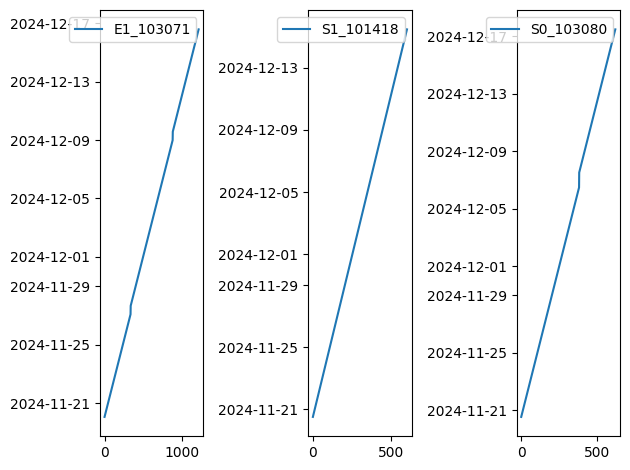

In [4]:
print(waves_E1_103071['Time'])
plt.subplot(1,3,1)
plt.plot(waves_E1_103071['Time'], label='E1_103071')
plt.legend()
plt.subplot(1,3,2)
plt.plot(waves_S1_101418['Time'], label='S1_101418')
plt.legend()
plt.subplot(1,3,3)
plt.plot(waves_S0_103080['Time'], label='S0_103080')
plt.legend()
plt.tight_layout()


In [5]:
#Function to convert unix timestamp in ns to regular datetime in UTC
def unix_ns_to_datetime(unix_ns_array):
    dates = []
    for date in unix_ns_array:
        seconds = date // 1_000_000_000
        nanoseconds = date % 1_000_000_000
        python_datetime = datetime.datetime.utcfromtimestamp(seconds) + datetime.timedelta(microseconds=nanoseconds / 1000)
        dates.append(python_datetime)
    return dates

In [6]:
waves_E1_103071["Datetime"] = pd.DataFrame([])
waves_S1_101418["Datetime"] = pd.DataFrame([])
waves_S0_103080["Datetime"] = pd.DataFrame([])
#Applying the function to convert for datetime
try :
    #Applying the function to convert for datetime
    unix_ns_array = waves_E1_103071["Time"]
    waves_E1_103071["Datetime"] = (unix_ns_to_datetime(unix_ns_array[0].values))
    unix_ns_array = waves_S1_101418["Time"]
    waves_S1_101418["Datetime"] = (unix_ns_to_datetime(unix_ns_array[0].values))   
    unix_ns_array = waves_S0_103080["Time"]
    waves_S0_103080["Datetime"] = (unix_ns_to_datetime(unix_ns_array[0].values))  
except Exception as e: 
    print(e)
    print("Macs and Windows require different methods to convert timestamps for some reason.")
    waves_E1_103071["Datetime"] = waves_E1_103071["Time"].values
    waves_S1_101418["Datetime"] = waves_S1_101418["Time"].values
    waves_S0_103080["Datetime"] = waves_S0_103080["Time"].values
    pass
finally :
    print(waves_S0_103080["Datetime"])


ufunc 'floor_divide' cannot use operands with types dtype('<M8[ns]') and dtype('int64')
Macs and Windows require different methods to convert timestamps for some reason.
[['2024-11-20T12:30:00.125792000']
 ['2024-11-20T13:30:00.126000000']
 ['2024-11-20T14:30:00.126107000']
 ['2024-11-20T15:30:00.125792000']
 ['2024-11-20T16:30:00.126111000']
 ['2024-11-20T17:30:00.126107000']
 ['2024-11-20T18:30:00.126104000']
 ['2024-11-20T19:30:00.126000000']
 ['2024-11-20T20:30:00.126107000']
 ['2024-11-20T21:30:00.126104000']
 ['2024-11-20T22:30:00.126000000']
 ['2024-11-20T23:30:00.126107000']
 ['2024-11-21T00:30:00.126104000']
 ['2024-11-21T01:30:00.126111000']
 ['2024-11-21T02:30:00.126107000']
 ['2024-11-21T03:30:00.126104000']
 ['2024-11-21T04:30:00.126000000']
 ['2024-11-21T05:30:00.126107000']
 ['2024-11-21T06:30:00.126104000']
 ['2024-11-21T07:30:00.126111000']
 ['2024-11-21T08:30:00.126107000']
 ['2024-11-21T09:30:00.126104000']
 ['2024-11-21T10:30:00.126000000']
 ['2024-11-21T11:30:00.12

In [44]:
#defining the start and end of the data
starttime = pd.to_datetime("2024-11-21 6:10:00", format = '%Y-%m-%d %H:%M:%S') #For deployment 1, S0 was deployed at 11 am EDT so 3 pm UTC
endtime = pd.to_datetime("2024-12-16 5:30:00", format = '%Y-%m-%d %H:%M:%S') #S0 retrieved at 1:30 pm EDT so 5:30 pm UTC

**Mean Period**

The mean wave period has units of seconds. It is recorded as the average of the ensemble wave periods for each chunk.  NOTE: We have a large gap in data here and need to look into why

In [45]:
print(waves_E1_103071['GroupSpeed'].iloc[70:80])

           0
70  2.896038
71  2.901433
72  2.908288
73  2.916132
74  2.922018
75  2.926549
76  2.929424
77  2.930226
78  2.929731
79  2.929796


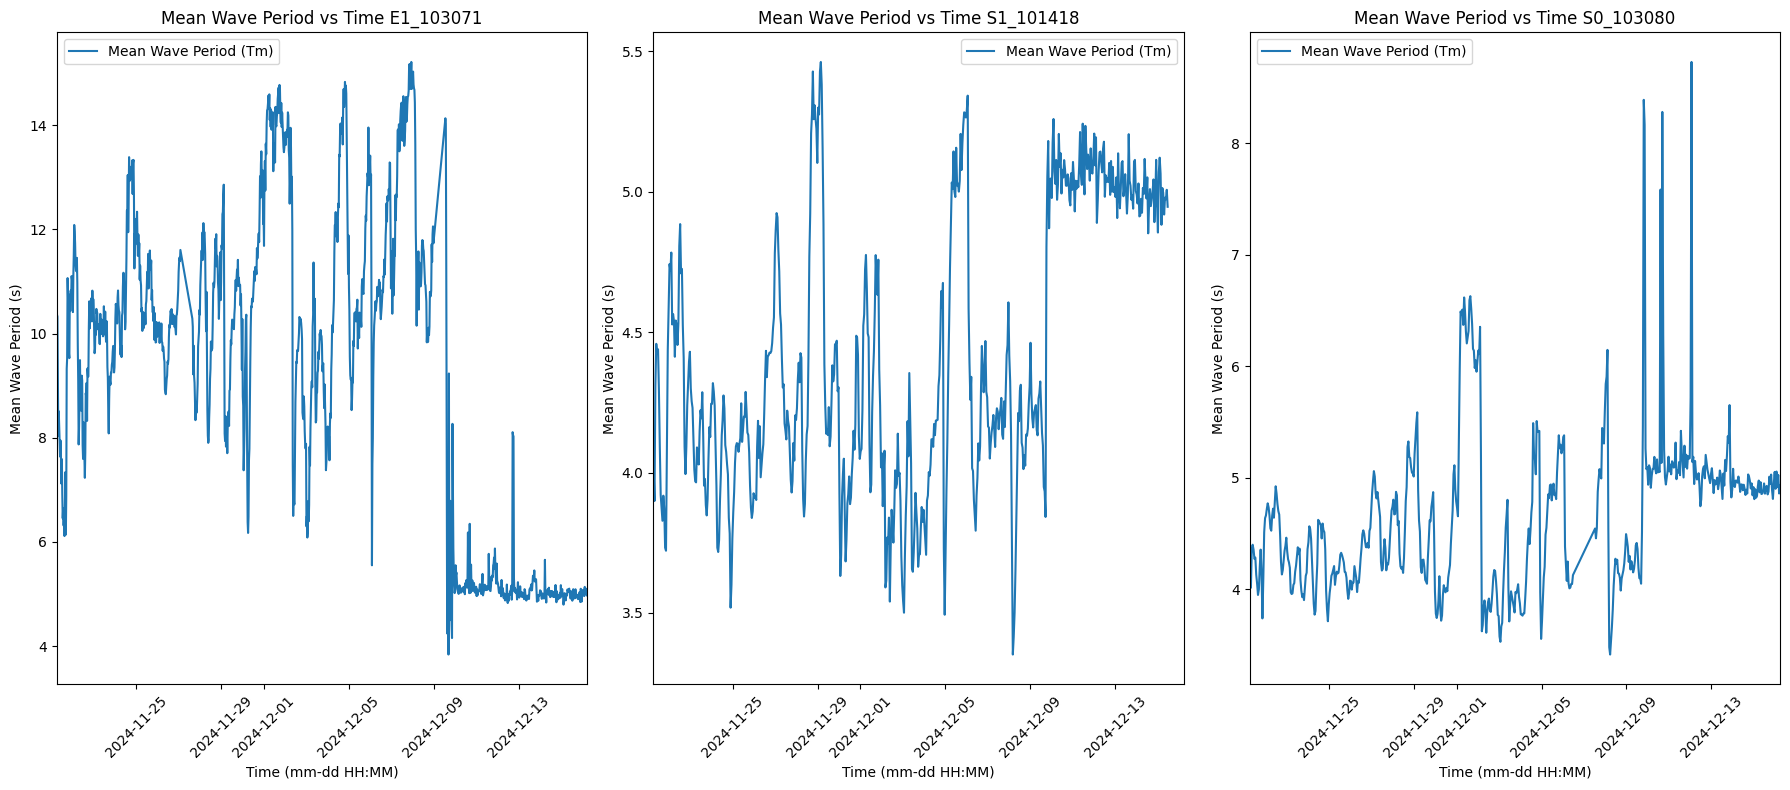

In [46]:
# Plot Mean Wave Period vs Time
fig=plt.figure(figsize=(18,8))

plt.subplot(1,3,1)
plt.plot(waves_E1_103071["Datetime"], waves_E1_103071["MeanPeriod"], label="Mean Wave Period (Tm)")
# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.title("Mean Wave Period vs Time E1_103071")
plt.xlim(starttime, endtime)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)

plt.subplot(1,3,2)
plt.plot(waves_S1_101418["Datetime"], waves_S1_101418["MeanPeriod"], label="Mean Wave Period (Tm)")
# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.title("Mean Wave Period vs Time S1_101418")
plt.xlim(starttime, endtime)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)


plt.subplot(1,3,3)
plt.plot(waves_S0_103080["Datetime"], waves_S0_103080["MeanPeriod"], label="Mean Wave Period (Tm)")
# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.title("Mean Wave Period vs Time S0_103080")
plt.xlim(starttime, endtime)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()

**Significant Wave Height**

The significant wave height has units of meters.

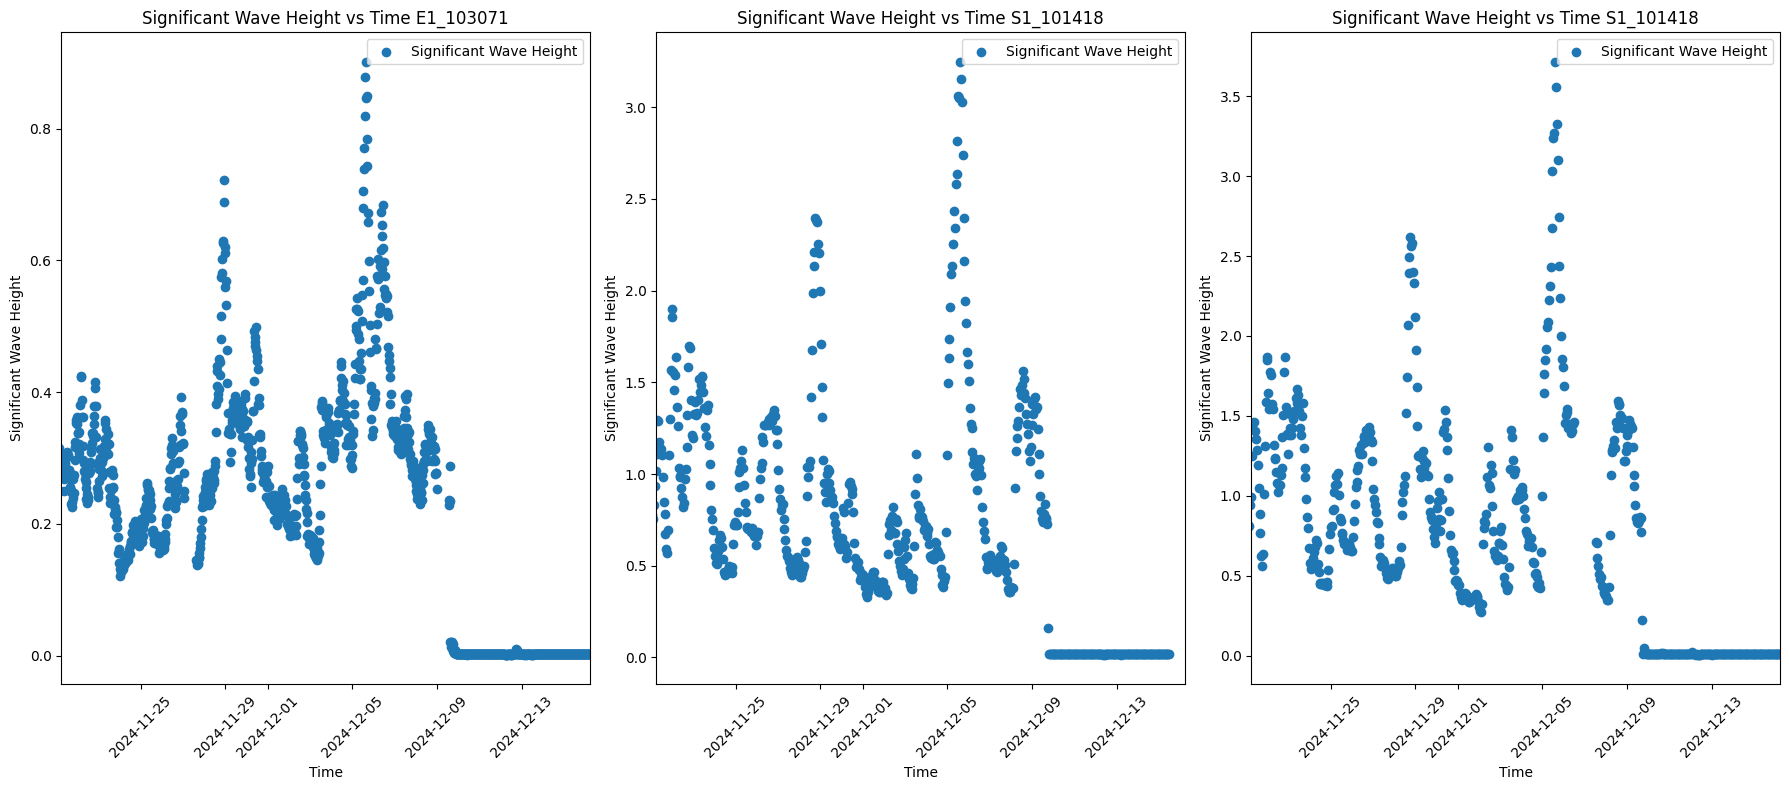

In [47]:
# Plot Mean Wave Period vs Time


fig=plt.figure(figsize=(18,8))

plt.subplot(1,3,1)
plt.scatter(waves_E1_103071["Datetime"], waves_E1_103071["SignificantWaveHeight"], label="Significant Wave Height")

# Formatting
plt.xlabel("Time")
plt.ylabel("Significant Wave Height")
plt.title("Significant Wave Height vs Time E1_103071")
plt.xlim(starttime, endtime)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)

plt.subplot(1,3,2)
plt.scatter(waves_S1_101418["Datetime"], waves_S1_101418["SignificantWaveHeight"], label="Significant Wave Height")

# Formatting
plt.xlabel("Time")
plt.ylabel("Significant Wave Height")
plt.title("Significant Wave Height vs Time S1_101418")
plt.xlim(starttime, endtime)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)


plt.subplot(1,3,3)
plt.scatter(waves_S0_103080["Datetime"], waves_S0_103080["SignificantWaveHeight"], label="Significant Wave Height")

# Formatting
plt.xlabel("Time")
plt.ylabel("Significant Wave Height")
plt.title("Significant Wave Height vs Time S1_101418")
plt.xlim(starttime, endtime)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)


plt.show()

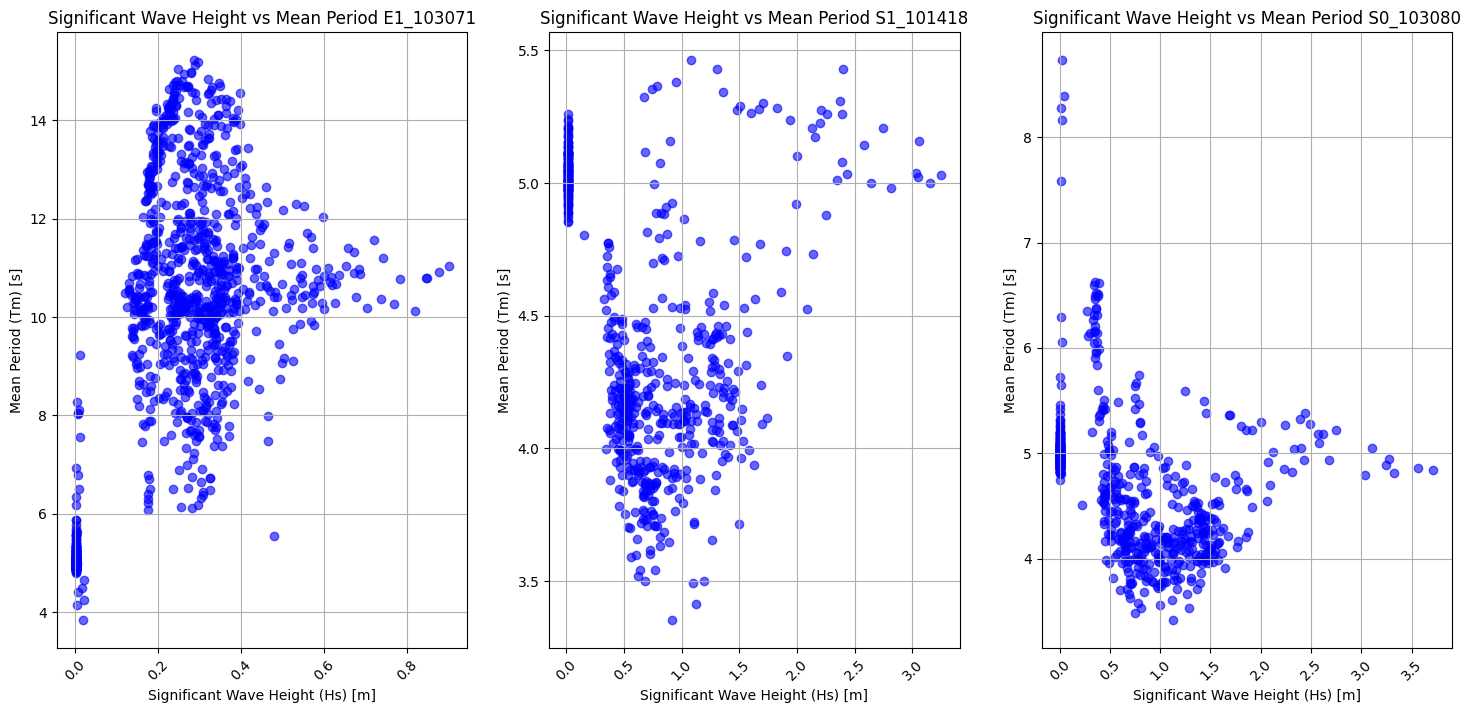

In [48]:
#Plot mean wave period vs significant wave height, you would expect larger waves to have longer periods
# Plot Mean Wave Period vs Significant wave height
fig=plt.figure(figsize=(18,8))

plt.subplot(1,3,1)
plt.scatter(waves_E1_103071['SignificantWaveHeight'], waves_E1_103071['MeanPeriod'], c='blue', alpha=0.6)
plt.title('Significant Wave Height vs Mean Period E1_103071')
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel('Mean Period (Tm) [s]')
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(1,3,2)
plt.scatter(waves_S1_101418['SignificantWaveHeight'], waves_S1_101418['MeanPeriod'], c='blue', alpha=0.6)
plt.title('Significant Wave Height vs Mean Period S1_101418')
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel('Mean Period (Tm) [s]')
plt.xticks(rotation=45)
plt.grid(True)


plt.subplot(1,3,3)
plt.scatter(waves_S0_103080['SignificantWaveHeight'], waves_S0_103080['MeanPeriod'], c='blue', alpha=0.6)
plt.title('Significant Wave Height vs Mean Period S0_103080')
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel('Mean Period (Tm) [s]')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

**Group Wave Speed**

The group wave speed is calculated in m/s for every hour in the deployment. 

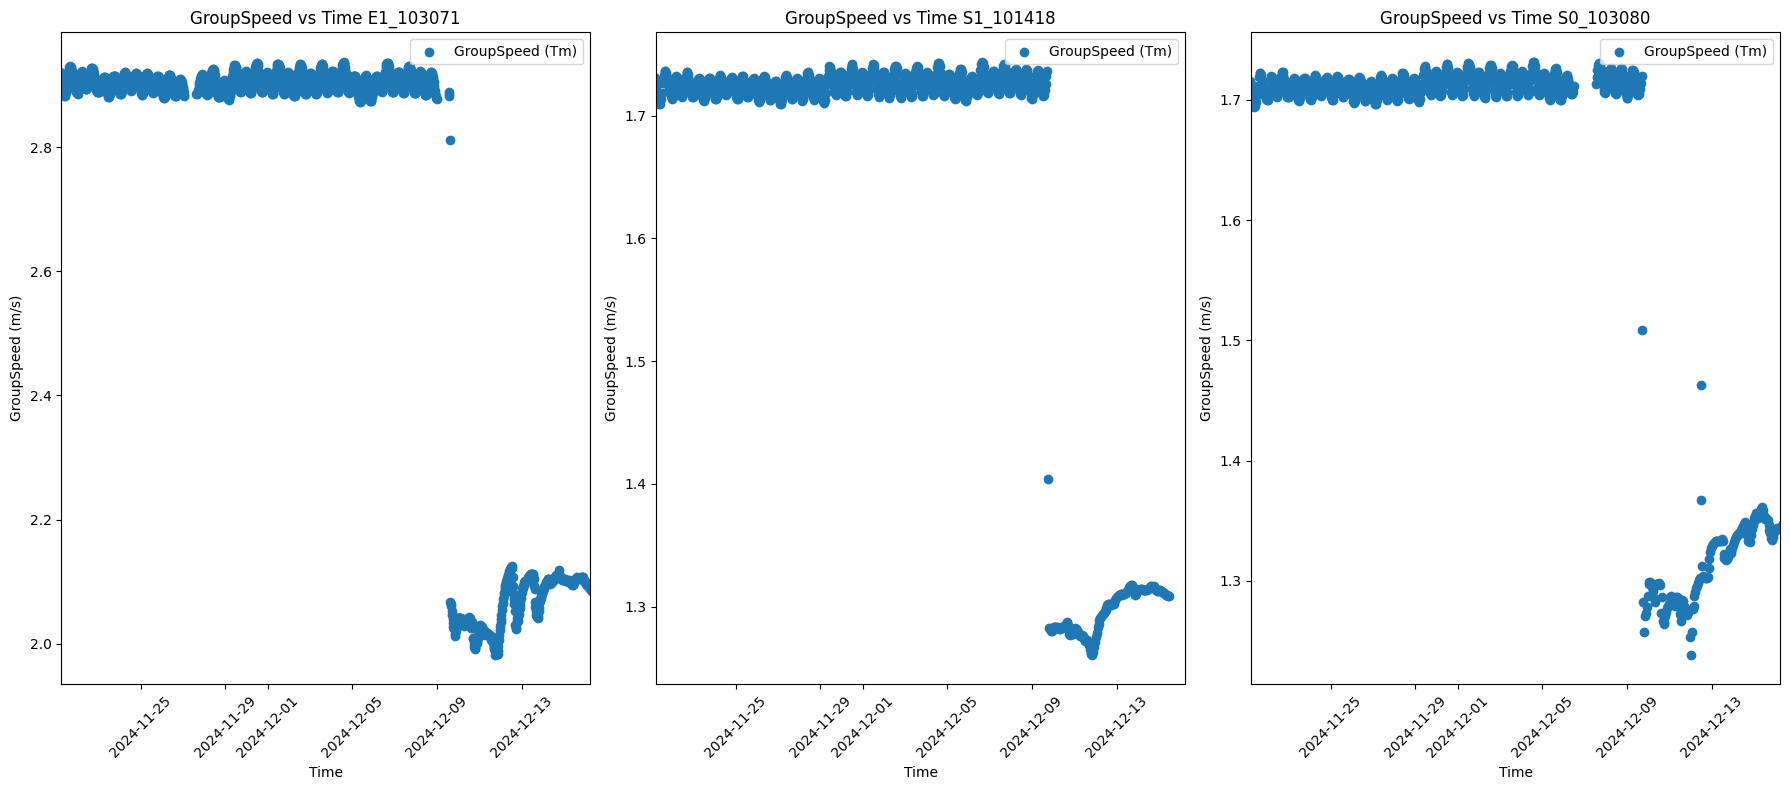

In [49]:
# Plot Group Wave Speed vs Time
fig=plt.figure(figsize=(18,8))

plt.subplot(1,3,1)
plt.scatter(waves_E1_103071["Datetime"], waves_E1_103071["GroupSpeed"], label="GroupSpeed (Tm)")

# Formatting
plt.xlabel("Time")
plt.ylabel("GroupSpeed (m/s)")
plt.title("GroupSpeed vs Time E1_103071")
plt.xlim(starttime, endtime)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)

plt.subplot(1,3,2)
plt.scatter(waves_S1_101418["Datetime"], waves_S1_101418["GroupSpeed"], label="GroupSpeed (Tm)")

# Formatting
plt.xlabel("Time")
plt.ylabel("GroupSpeed (m/s)")
plt.title("GroupSpeed vs Time S1_101418")
plt.xlim(starttime, endtime)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)

plt.subplot(1,3,3)
plt.scatter(waves_S0_103080["Datetime"], waves_S0_103080["GroupSpeed"], label="GroupSpeed (Tm)")

# Formatting
plt.xlabel("Time")
plt.ylabel("GroupSpeed (m/s)")
plt.title("GroupSpeed vs Time S0_103080")
plt.xlim(starttime, endtime)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()

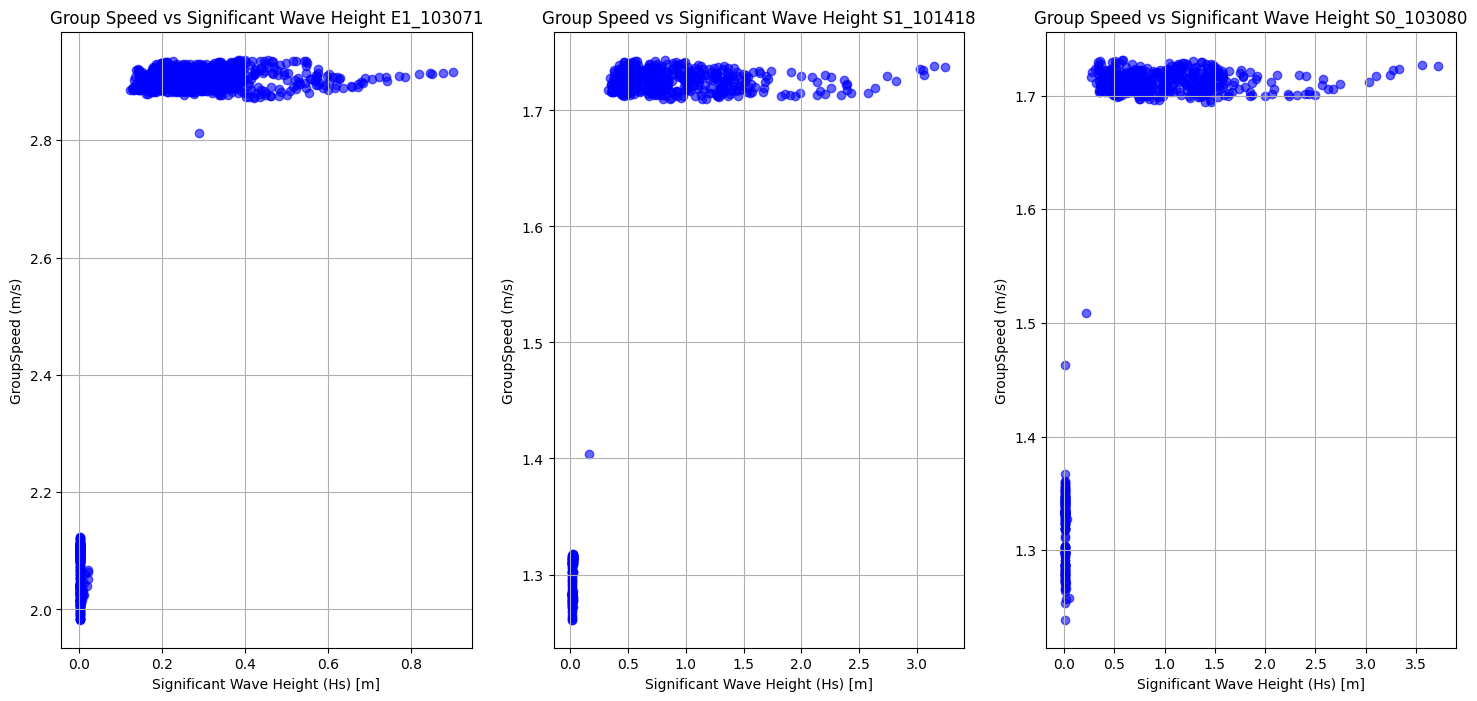

In [50]:
#Look at correlation between wave height and wave group speed
fig=plt.figure(figsize=(18,8))

plt.subplot(1,3,1)
plt.scatter(waves_E1_103071['SignificantWaveHeight'], waves_E1_103071['GroupSpeed'], c='blue', alpha=0.6)
plt.title('Group Speed vs Significant Wave Height E1_103071')
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel("GroupSpeed (m/s)")
plt.grid(True)

plt.subplot(1,3,2)
plt.scatter(waves_S1_101418['SignificantWaveHeight'], waves_S1_101418['GroupSpeed'], c='blue', alpha=0.6)
plt.title('Group Speed vs Significant Wave Height S1_101418')
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel("GroupSpeed (m/s)")
plt.grid(True)

plt.subplot(1,3,3)
plt.scatter(waves_S0_103080['SignificantWaveHeight'], waves_S0_103080['GroupSpeed'], c='blue', alpha=0.6)
plt.title('Group Speed vs Significant Wave Height S0_103080')
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel("GroupSpeed (m/s)")
plt.grid(True)
plt.show()

**Wave Direction and Spread**

The wave direction contains the average direction of wave groups and the spread of this measurement. The direction is measured in degrees from North, i.e. East = 90, South = 180, West = 270, North = 0 or 360. The spread refers to the deviation in degrees that the wave packets may travel in from the mean direction. So a direction of 90 and a spread of 45 means you would expect the wave packets to be traveling on average due east with parts of the wave packet propogating from ENE to ESE.

(array([20052., 20056., 20058., 20062., 20066., 20070.]),
 [Text(20052.0, 0, '2024-11-25'),
  Text(20056.0, 0, '2024-11-29'),
  Text(20058.0, 0, '2024-12-01'),
  Text(20062.0, 0, '2024-12-05'),
  Text(20066.0, 0, '2024-12-09'),
  Text(20070.0, 0, '2024-12-13')])

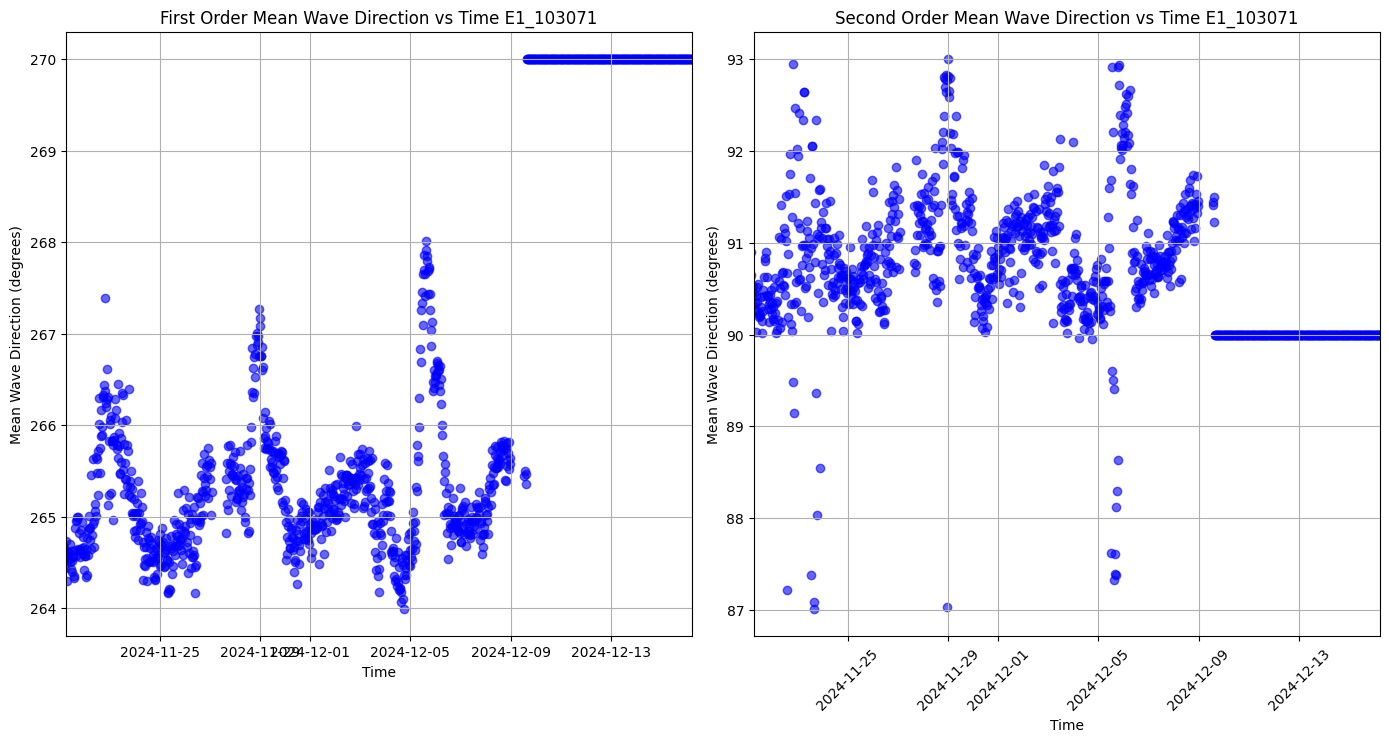

In [51]:
#Code to compare first and second order mean wave direction 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
ax1.scatter(waves_E1_103071["Datetime"], waves_E1_103071["MeanDirection1"], c='blue', alpha=0.6)
ax1.set_title('First Order Mean Wave Direction vs Time E1_103071')
ax2.scatter(waves_E1_103071["Datetime"], waves_E1_103071["MeanDirection2"], c='blue', alpha=0.6)
ax2.set_title('Second Order Mean Wave Direction vs Time E1_103071')
for ax in (ax1, ax2):
    ax.set_xlabel('Time')
    ax.set_ylabel('Mean Wave Direction (degrees)')
    ax.set_xlim(starttime, endtime)
    ax.grid(True)
plt.tight_layout()  
plt.xticks(rotation=45)  

(array([20052., 20056., 20058., 20062., 20066., 20070.]),
 [Text(20052.0, 0, '2024-11-25'),
  Text(20056.0, 0, '2024-11-29'),
  Text(20058.0, 0, '2024-12-01'),
  Text(20062.0, 0, '2024-12-05'),
  Text(20066.0, 0, '2024-12-09'),
  Text(20070.0, 0, '2024-12-13')])

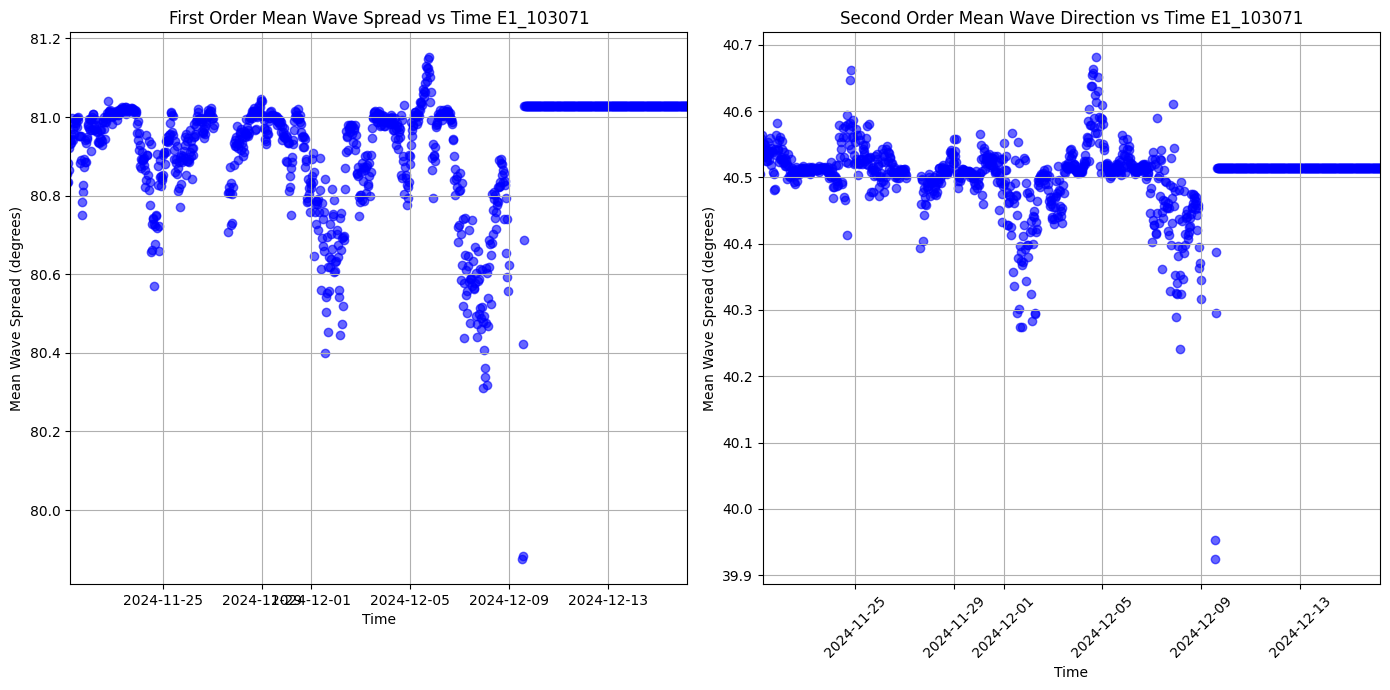

In [52]:
#This compares the first and second order spreads 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
plt.xticks(rotation=45) 
ax1.scatter(waves_E1_103071["Datetime"], waves_E1_103071["MeanSpread1"], c='blue', alpha=0.6)
ax1.set_title('First Order Mean Wave Spread vs Time E1_103071')
ax2.scatter(waves_E1_103071["Datetime"], waves_E1_103071["MeanSpread2"], c='blue', alpha=0.6)
ax2.set_title('Second Order Mean Wave Direction vs Time E1_103071')
for ax in (ax1, ax2):
    ax.set_xlabel('Time')
    ax.set_ylabel('Mean Wave Spread (degrees)')
    ax.set_xlim(starttime, endtime)
    ax.grid(True)
plt.tight_layout()    
plt.xticks(rotation=45) 

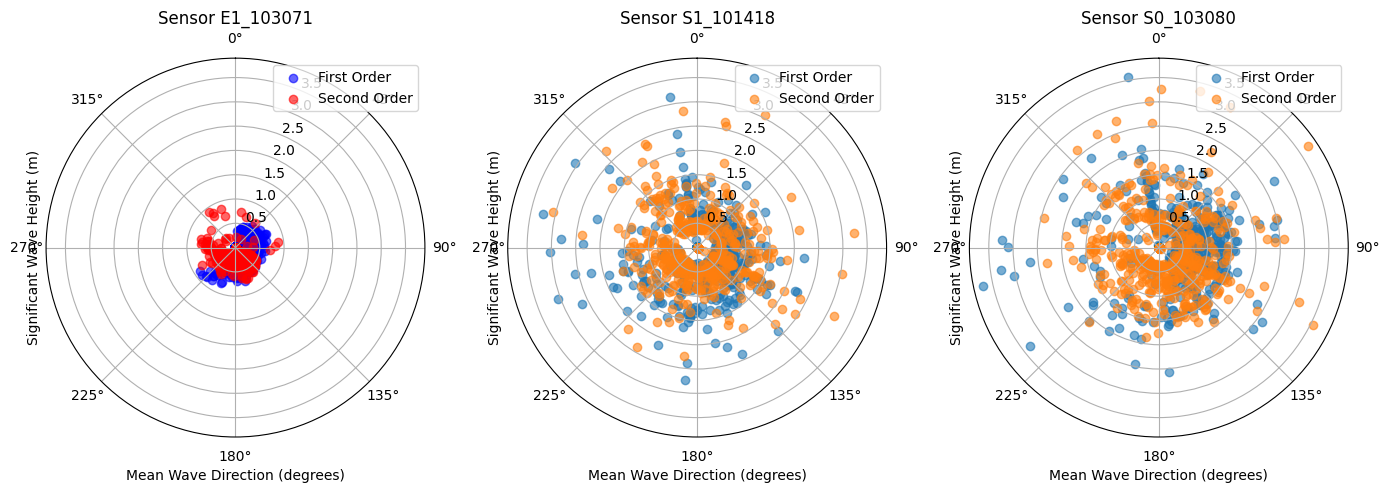

In [53]:
#Create a polar plot of wave direction with signficant wave height as the color to show the intensity of the waves
#Use the spread of the wave direction to show the variability of the waves
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 7),sharey=True)
# Plotting the wave direction
ax1.scatter((waves_E1_103071['MeanDirection1']),waves_E1_103071['SignificantWaveHeight'] ,c = 'blue', alpha=0.6, label='First Order')
ax1.scatter((waves_E1_103071['MeanDirection2']),waves_E1_103071['SignificantWaveHeight'] ,c = 'red', alpha=0.6, label='Second Order')
ax1.set_title('Sensor E1_103071')

ax2.scatter((waves_S1_101418['MeanDirection1']) ,waves_S1_101418['SignificantWaveHeight'] , alpha=0.6, label='First Order')
ax2.scatter((waves_S1_101418['MeanDirection2']) ,waves_S1_101418['SignificantWaveHeight'] , alpha=0.6, label='Second Order')
ax2.set_title('Sensor S1_101418')

ax3.scatter((waves_S0_103080['MeanDirection1']) ,waves_S0_103080['SignificantWaveHeight'] , alpha=0.6, label='First Order')
ax3.scatter((waves_S0_103080['MeanDirection2']) ,waves_S0_103080['SignificantWaveHeight'] , alpha=0.6, label='Second Order')
ax3.set_title('Sensor S0_103080')
for ax in (ax1, ax2, ax3):
    ax.legend(loc='upper right')   
    ax.set_theta_direction(-1)  # Set the direction of the angle to be clockwise
    ax.set_theta_zero_location('N')  # Set the zero angle to the top
    ax.set_xlabel('Mean Wave Direction (degrees)')
    ax.set_ylabel('Significant Wave Height (m)')
plt.tight_layout()




**Depth Averaged Current Velocity**

The Depth Averaged Current Velocity returns the average magnitude of the current across all depths in m/s. 

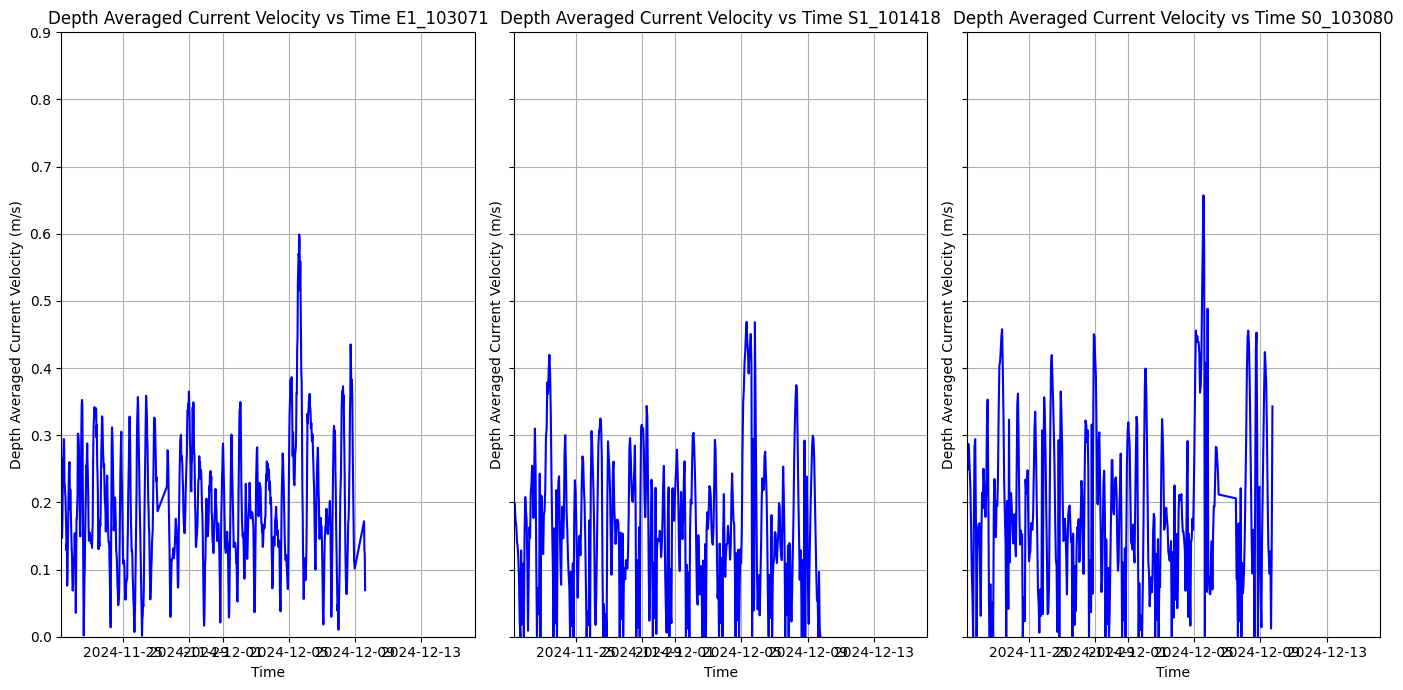

In [54]:
#This code plots the Depth Averaged Current Velocity vs Time for both sensors
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 7), sharey=True)
ax1.plot(waves_E1_103071["Datetime"], waves_E1_103071['DepthAveragedCurrentVelocity'], label='Depth Averaged Current Velocity', color='blue')
ax1.set_title('Depth Averaged Current Velocity vs Time E1_103071')
ax2.plot(waves_S1_101418["Datetime"], waves_S1_101418['DepthAveragedCurrentVelocity'], label='Depth Averaged Current Velocity', color='blue')
ax2.set_title('Depth Averaged Current Velocity vs Time S1_101418')
ax3.plot(waves_S0_103080["Datetime"], waves_S0_103080['DepthAveragedCurrentVelocity'], label='Depth Averaged Current Velocity', color='blue')
ax3.set_title('Depth Averaged Current Velocity vs Time S0_103080')

for ax in (ax1, ax2, ax3):
    ax.set_xlabel('Time')
    ax.set_ylabel('Depth Averaged Current Velocity (m/s)')
    ax.set_xlim(starttime, endtime)
    ax.grid(True)
    ax.set_ylim(0,0.9)
plt.tight_layout()

(0.0, 0.9)

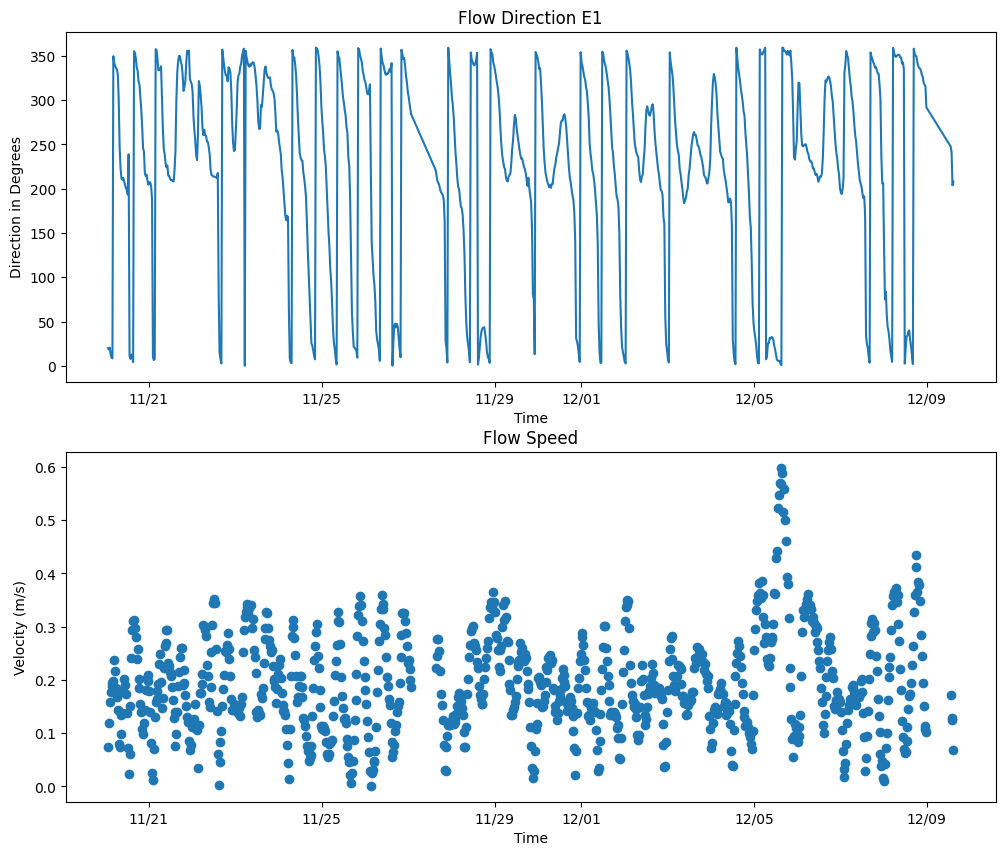

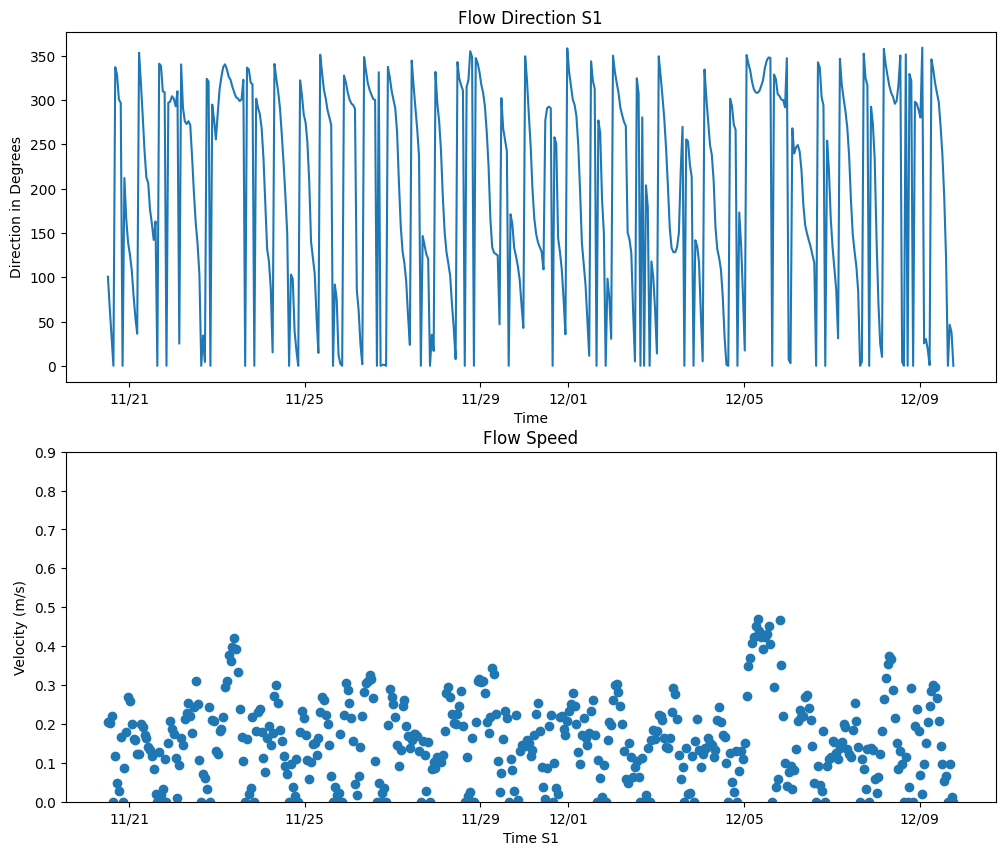

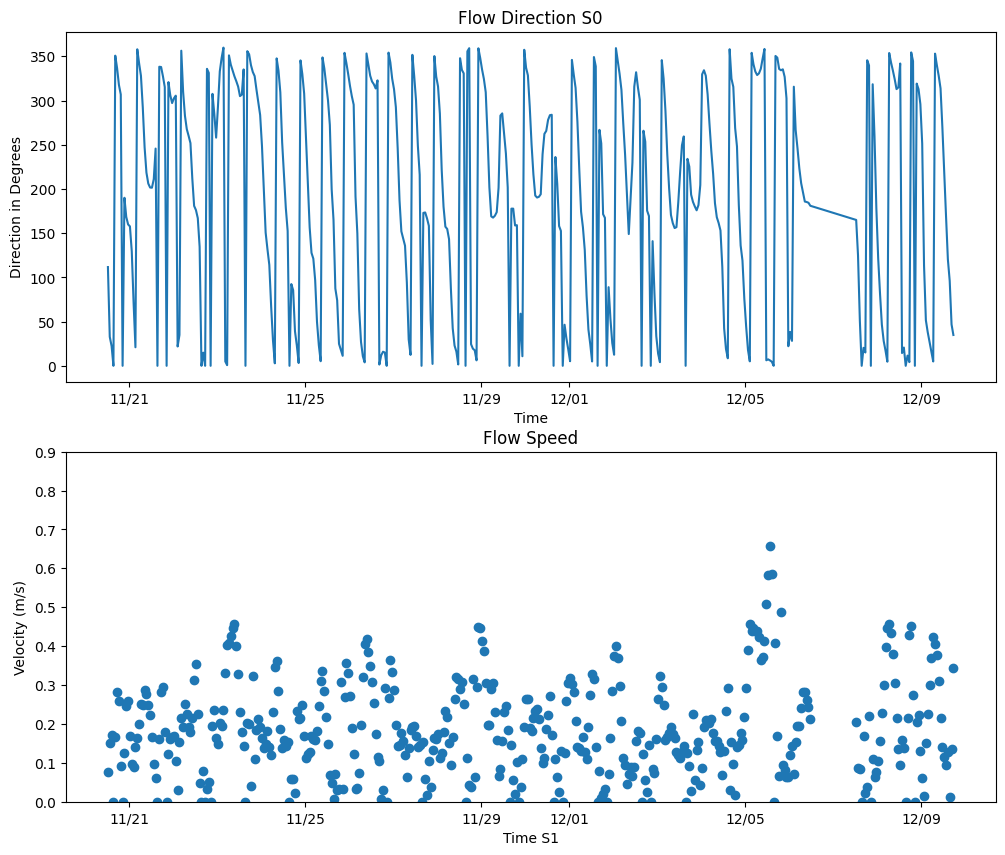

In [55]:
figs, axs = plt.subplots(2, 1, figsize=(12, 10))
gg = axs[0].plot(waves_E1_103071["Time"], waves_E1_103071["DepthAveragedFlowDirection"])
# plt.colorbar(gg, label="Speed (m/s)")
axs[0].set_title("Flow Direction E1")
axs[0].set_ylabel("Direction in Degrees")
axs[0].set_xlabel("Time")
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))


gg1 = axs[1].scatter(waves_E1_103071["Time"].values, waves_E1_103071["DepthAveragedCurrentVelocity"])
axs[1].set_ylabel("Velocity (m/s)")
axs[1].set_xlabel("Time")
axs[1].set_title("Flow Speed")
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))

# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_flowdir.png")

figs, axs = plt.subplots(2, 1, figsize=(12, 10))
gg = axs[0].plot(waves_S1_101418["Time"].values, waves_S1_101418["DepthAveragedFlowDirection"])
# plt.colorbar(gg, label="Speed (m/s)")
axs[0].set_title("Flow Direction S1")
axs[0].set_ylabel("Direction in Degrees")
axs[0].set_xlabel("Time")
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))


gg1 = axs[1].scatter(waves_S1_101418["Time"].values, waves_S1_101418["DepthAveragedCurrentVelocity"])
axs[1].set_ylabel("Velocity (m/s)")
axs[1].set_xlabel("Time S1")
axs[1].set_title("Flow Speed")
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
axs[1].set_ylim(0, 0.9)
# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_flowdir.png")

figs, axs = plt.subplots(2, 1, figsize=(12, 10))
gg = axs[0].plot(waves_S0_103080["Time"].values, waves_S0_103080["DepthAveragedFlowDirection"])
# plt.colorbar(gg, label="Speed (m/s)")
axs[0].set_title("Flow Direction S0")
axs[0].set_ylabel("Direction in Degrees")
axs[0].set_xlabel("Time")
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))


gg1 = axs[1].scatter(waves_S0_103080["Time"].values, waves_S0_103080["DepthAveragedCurrentVelocity"])
axs[1].set_ylabel("Velocity (m/s)")
axs[1].set_xlabel("Time S1")
axs[1].set_title("Flow Speed")
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
axs[1].set_ylim(0, 0.9)
# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\{sensor_id}_flowdir.png")


**Depth Averaged Current Direction**

This returns the average direction of current flow across all depths in degrees, in cases with lots of turbulence this may not be an accurate way to visualize this. 

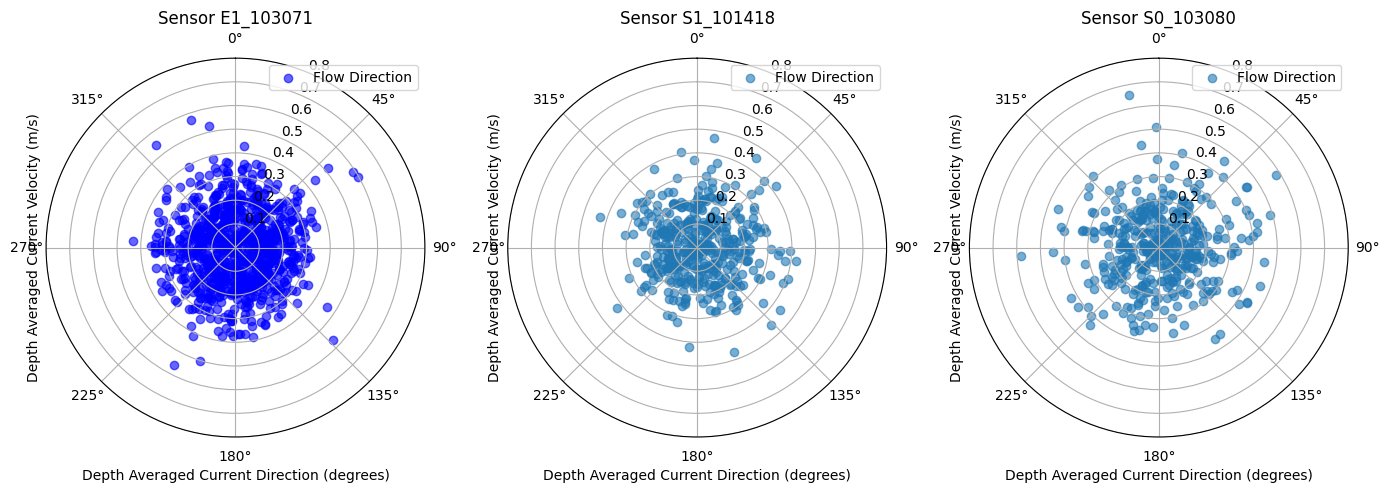

In [56]:
#Create a polar plot of flow direciton with average flow velocity to show the intensity of the flow
#Use the spread of the wave direction to show the variability of the waves
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 7),sharey=True)
# Plotting the wave direction
ax1.scatter(waves_E1_103071['DepthAveragedFlowDirection'],waves_E1_103071['DepthAveragedCurrentVelocity'] ,c = 'blue', alpha=0.6, label='Flow Direction')
ax1.set_title('Sensor E1_103071')
ax2.scatter((waves_S1_101418['DepthAveragedFlowDirection']) ,waves_S1_101418['DepthAveragedCurrentVelocity'] , alpha=0.6, label='Flow Direction')
ax2.set_title('Sensor S1_101418')
ax3.scatter((waves_S0_103080['DepthAveragedFlowDirection']) ,waves_S0_103080['DepthAveragedCurrentVelocity'] , alpha=0.6, label='Flow Direction')
ax3.set_title('Sensor S0_103080')
for ax in (ax1, ax2, ax3):
    ax.legend(loc='upper right')   
    ax.set_theta_direction(-1)  # Set the direction of the angle to be clockwise
    ax.set_theta_zero_location('N')  # Set the zero angle to the top
    ax.set_xlabel('Depth Averaged Current Direction (degrees)')
    ax.set_ylabel('Depth Averaged Current Velocity (m/s)')
    ax.set_ylim(0,0.8)
plt.tight_layout()


**Energy Spectrum**

The energy spectrum was calculated per each time step of the data collection, and is represented by the variable PressureSpectra. Contrary to the past variables we have calculated and visualizzed, the energy spectrum is in the frequency domain, rather than in the time domain. However, there is an energy spectrum for each time step, so we need to use a spectrogram to best visualize how the energy is changing at each frequency over time.

In [57]:
df=waves_E1_103071['PressureSpectra']
print(df.shape)
df=df.iloc[:,:-1]

(1221, 170)


In [58]:
freq_nonan=waves_E1_103071['Frequencies'].fillna(0) # fill NaNs with zeros for plotting
fmax=float(freq_nonan.loc[126]) # grab maximum frequency for plotting
print(fmax)


0.24609375


C:\Users\lwlav\AppData\Local\Temp\ipykernel_27308\1618630041.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  fmax=float(freq_nonan.loc[126]) # grab maximum frequency for plotting


In [59]:
# create a meshgrid of time and frequency
x,y=np.meshgrid(waves_E1_103071['Datetime'],freq_nonan)
z=df
print(z.shape,x.shape,y.shape)

(1221, 169) (169, 1221) (169, 1221)


This plot is lining up well with individual spectra, the weird vertical line is cutoff point for time, I beleive

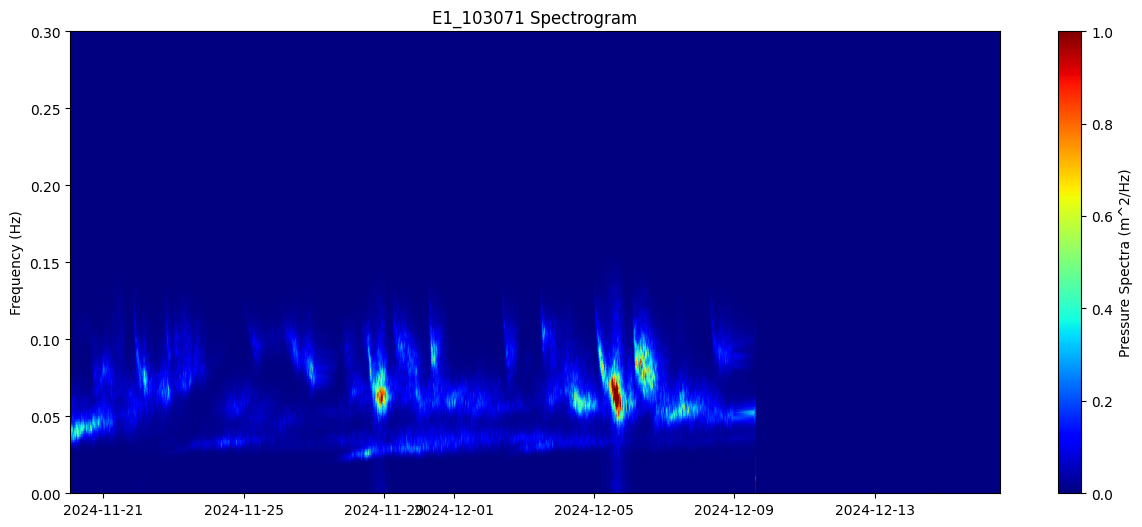

In [60]:
# Plot Energy Spectra over time per cell
plt.figure(figsize=(15,6))
plt.pcolormesh(
    x,y,z.T, cmap='jet', shading='gouraud', vmin=0, vmax=1
)
plt.ylim(top=0.3)
plt.ylabel("Frequency (Hz)")
plt.title('E1_103071 Spectrogram')
im1=plt.colorbar()
im1.ax.set_ylabel("Pressure Spectra (m^2/Hz)")
plt.show()
# plt.savefig(f"C:\\Users\\lwlav\\OneDrive\\Documents\\Summer 2024 CHAZ\\Figures\\FPS1E1spectrogram.png")

In [61]:
df=waves_S1_101418['PressureSpectra']
df=df.iloc[:,:-1]

In [62]:
freq_nonan=waves_S1_101418['Frequencies'].fillna(0) # fill NaNs with zeros for plotting
fmax=float(freq_nonan.loc[126]) # grab maximum frequency for plotting
print(fmax)

0.24609375


C:\Users\lwlav\AppData\Local\Temp\ipykernel_27308\134043482.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  fmax=float(freq_nonan.loc[126]) # grab maximum frequency for plotting


In [63]:
# create a meshgrid of time and frequency
x,y=np.meshgrid(waves_S1_101418['Datetime'],freq_nonan)
z=df


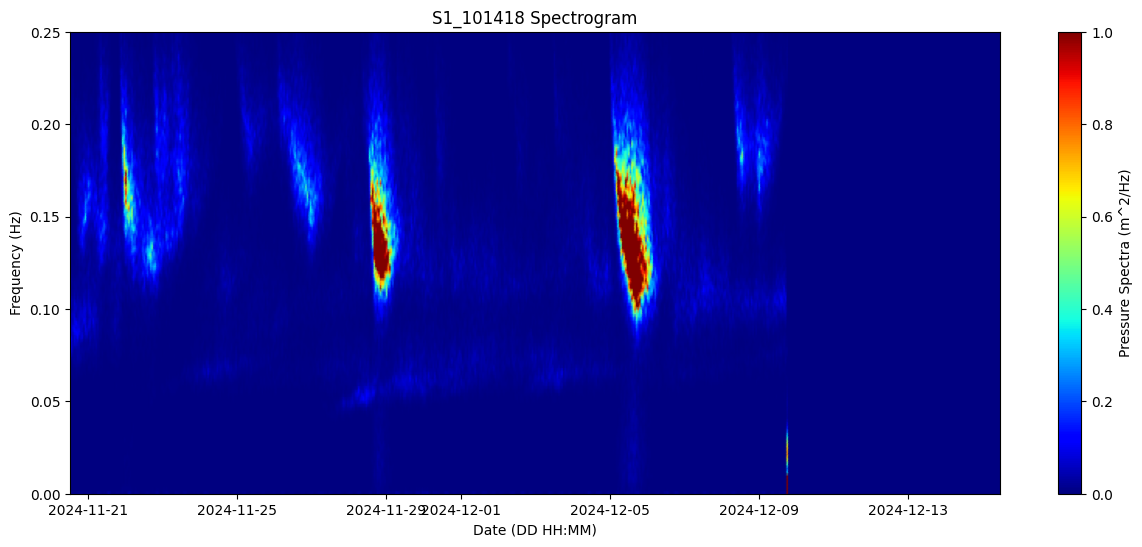

In [64]:
# Plot energy spectra over time per cell
plt.figure(figsize=(15,6))
plt.pcolormesh(
    x,y,z.T, cmap='jet', shading='gouraud', vmin=0, vmax=1
)
plt.ylim(top=0.25)
plt.xlabel("Date (DD HH:MM)")
plt.ylabel("Frequency (Hz)")
plt.title('S1_101418 Spectrogram')
im1=plt.colorbar()
im1.ax.set_ylabel("Pressure Spectra (m^2/Hz)")
plt.show()

In [65]:
df=waves_S0_103080['PressureSpectra']
df=df.iloc[:,:-1]

In [66]:
freq_nonan=waves_S0_103080['Frequencies'].fillna(0) # fill NaNs with zeros for plotting
fmax=float(freq_nonan.loc[126]) # grab maximum frequency for plotting
print(fmax)

0.24609375


C:\Users\lwlav\AppData\Local\Temp\ipykernel_27308\3697448984.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  fmax=float(freq_nonan.loc[126]) # grab maximum frequency for plotting


In [67]:
# create a meshgrid of time and frequency
x,y=np.meshgrid(waves_S0_103080['Datetime'],freq_nonan)
z=df

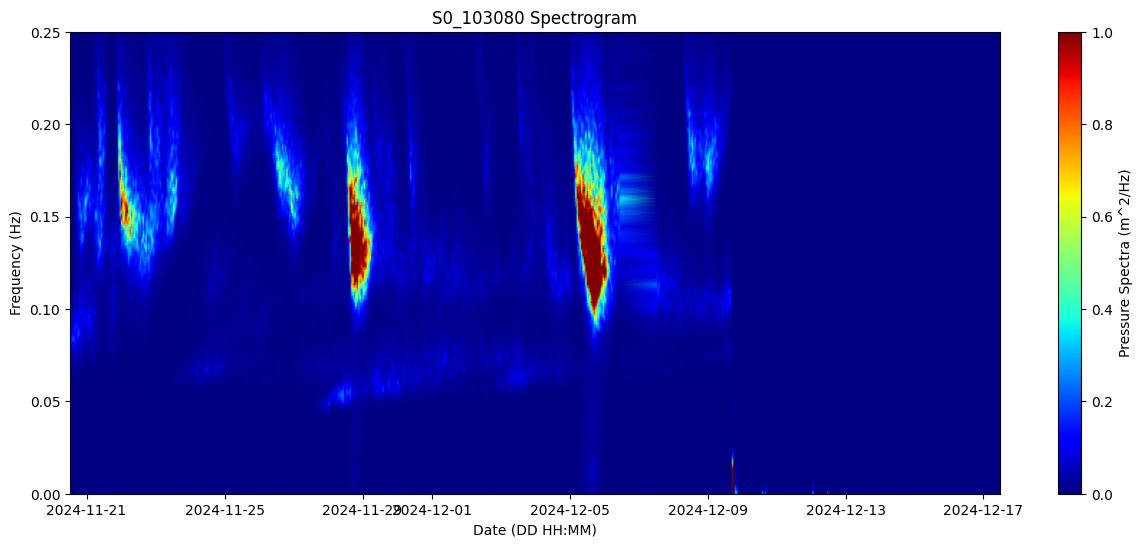

In [68]:
# Plot energy spectra over time per cell
plt.figure(figsize=(15,6))
plt.pcolormesh(
    x,y,z.T, cmap='jet', shading='gouraud', vmin=0, vmax=1
)
plt.ylim(top=0.25)
plt.xlabel("Date (DD HH:MM)")
plt.ylabel("Frequency (Hz)")
plt.title('S0_103080 Spectrogram')
im1=plt.colorbar()
im1.ax.set_ylabel("Pressure Spectra (m^2/Hz)")
plt.show()

**Data Comparison**

We can compare our data to that collected by the Coastal Ocean Research and Monitoring Program (CORMP). There is SOFAR spotter wave buoy located east of Bald Head Island at 33.8684 N 77.9396 W, and will be denoted at BHI_E. This is further onshore than where our ADCPs were recording data, however will still serve as valid comparison. There is another bouy located just outside of the shoals at 33.721 N 78.015 W, owned by the U.S. Army Corps of Engineers. This buoy is closer to lander S0 and S1, at a water depth of 13 m and will be denoted as USACE_41108.

In [69]:
# Read in BHI-E Data
BHI_E_path=r"Z:/deployment_1/BulkStats/CORMP_data/data_BHI_E.csv"
BHI_E_data=pd.read_csv(BHI_E_path,skiprows=11)

In [70]:
# Assign variables for BHI-E buoy
Bdf={}
Bdf["BTime"]=BHI_E_data['Time (America/New_York)']
Bdf["BSigWaveHeight"]=BHI_E_data['BHI-E Significant wave height (m)']
Bdf["BMeanPeriod"]=BHI_E_data['BHI-E Mean wave period (s)']
Bdf["BMeabWaveDirection"]=BHI_E_data['BHI-E Mean wave direction (deg N)']


In [71]:
# convert to datetime format
Bdf["BTime"] = pd.to_datetime(Bdf["BTime"])

start_date = '2024-08-19'
end_date = '2024-09-20'

# Convert start and end dates to datetime format
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

# Filter the data based on the date range
filtered_Bdf = {key: value[(Bdf["BTime"] >= start_date) & (Bdf["BTime"] <= end_date)] for key, value in Bdf.items()}

Bdf=filtered_Bdf

C:\Users\lwlav\AppData\Local\Temp\ipykernel_27308\1607421280.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Bdf["BTime"] = pd.to_datetime(Bdf["BTime"])


In [72]:
# read in USACE data
USACEpath=r"Z:/deployment_1/BulkStats/CORMP_data/41108h2024.txt"
df = pd.read_csv(USACEpath, delim_whitespace=True, header=1)

C:\Users\lwlav\AppData\Local\Temp\ipykernel_27308\2584233144.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(USACEpath, delim_whitespace=True, header=1)


In [73]:
# convert time
df.rename(columns={'#yr': 'yr'}, inplace=True)
df['Datetime'] = pd.to_datetime(df['yr'].astype(str) + '-' +
                                 df['mo'].astype(str).str.zfill(2) + '-' +
                                 df['dy'].astype(str).str.zfill(2) + ' ' +
                                 df['hr'].astype(str).str.zfill(2) + ':' +
                                 df['mn'].astype(str).str.zfill(2))

In [74]:
# Filter rows based on the date range
filtered_df = df[(df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)]
USACEdata=filtered_df
UStime=filtered_df['Datetime']

In [75]:
# assign variables for USACE buoy
USSigWaveHeight=USACEdata["m"]
USMeanPeriod=USACEdata["sec.1"]
USMeanWaveDirection=USACEdata["degT.1"]

Let's compare our data to that collected during the same time period through the CORMP buoy, starting with mean wave period.

In [76]:
# Define custom dates for the x-ticks
custom_xticks = [
    "08/20/24","08/24/24", "08/30/24", "09/04/24", "09/09/24", "09/13/24", "09/15/24", "09/19/24"
]
# Convert these dates to datetime format
custom_xticks = pd.to_datetime(custom_xticks, format='%m/%d/%y')

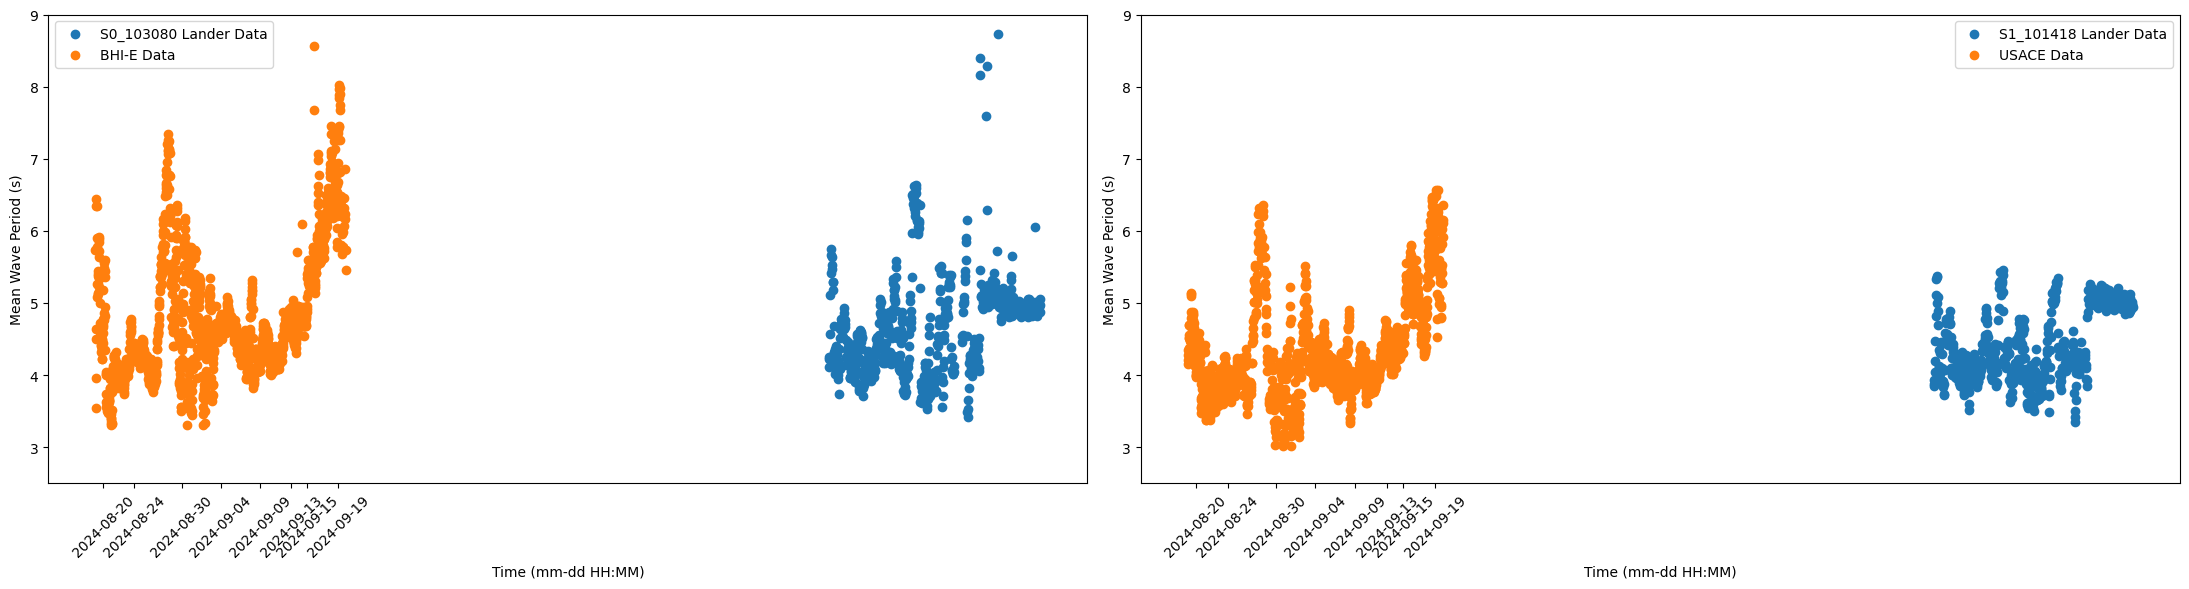

In [77]:
# Plot Mean Wave Period vs Time
fig=plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
plt.scatter(waves_S0_103080["Datetime"], waves_S0_103080["MeanPeriod"], label="S0_103080 Lander Data")
plt.scatter(Bdf["BTime"], Bdf["BMeanPeriod"], label="BHI-E Data")

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.ylim(2.5,9)
plt.legend()
plt.tight_layout()

plt.xticks(custom_xticks,rotation=45)

plt.subplot(1,2,2)
plt.scatter(waves_S1_101418["Datetime"], waves_S1_101418["MeanPeriod"], label="S1_101418 Lander Data")
plt.scatter(UStime, USMeanPeriod, label="USACE Data")

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Mean Wave Period (s)")
plt.ylim(2.5,9)
plt.legend()
plt.tight_layout()

plt.xticks(custom_xticks,rotation=45)


plt.show()

Explain differences between plots

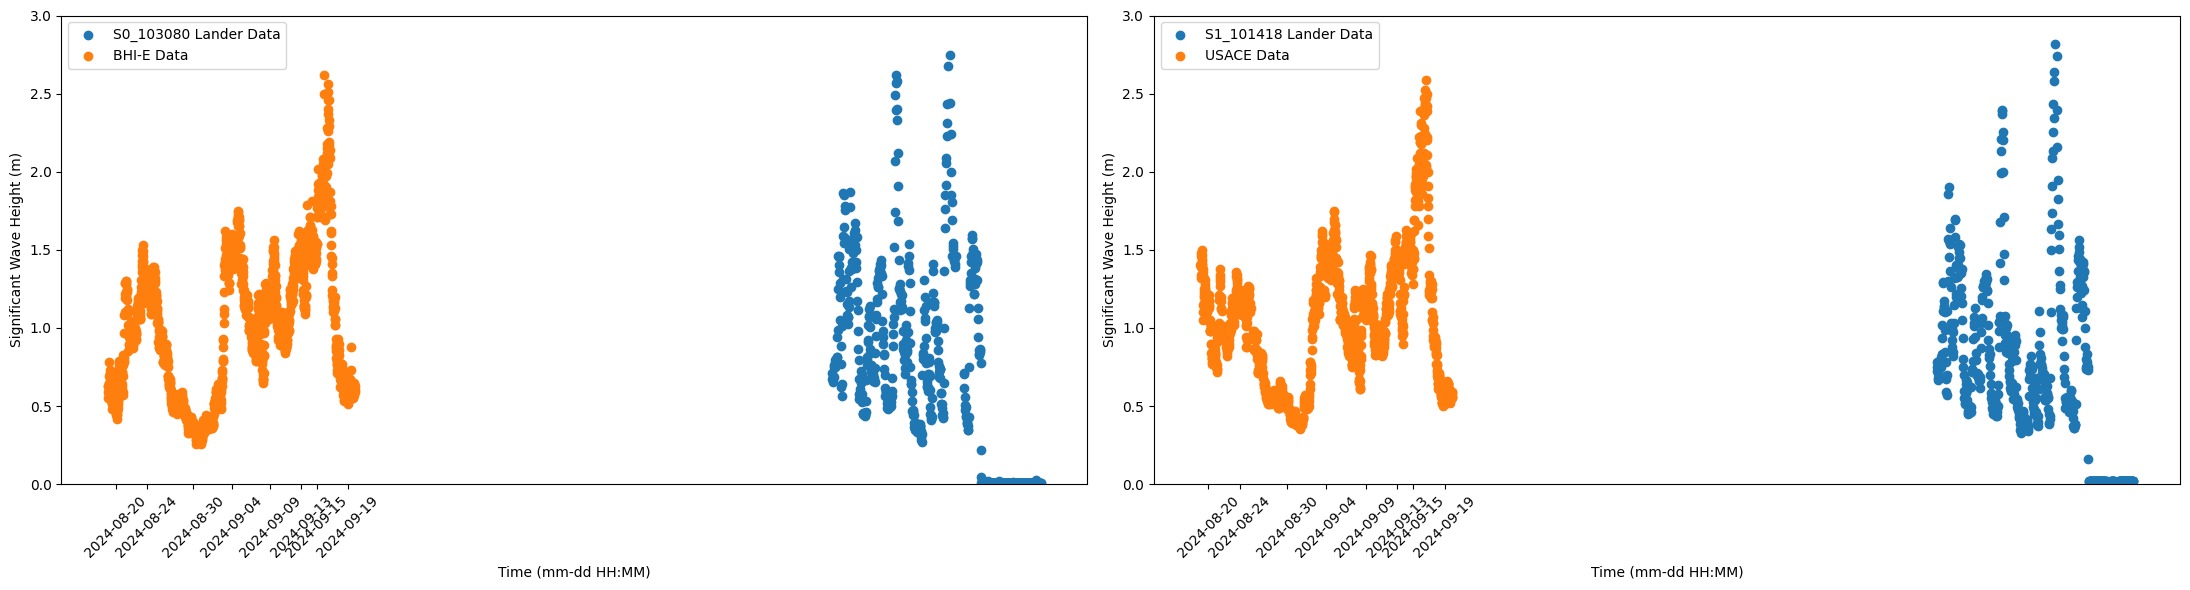

In [78]:
# Plot Significant Wave Height vs Time
fig=plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
plt.scatter(waves_S0_103080["Datetime"], waves_S0_103080['SignificantWaveHeight'], label="S0_103080 Lander Data")
plt.scatter(Bdf["BTime"], Bdf["BSigWaveHeight"], label="BHI-E Data")

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Significant Wave Height (m)")
plt.ylim(0,3)
plt.legend()
plt.tight_layout()

plt.xticks(custom_xticks,rotation=45)

plt.subplot(1,2,2)
plt.scatter(waves_S1_101418["Datetime"], waves_S1_101418['SignificantWaveHeight'], label="S1_101418 Lander Data")
plt.scatter(UStime, USSigWaveHeight, label="USACE Data")

# Formatting
plt.xlabel("Time (mm-dd HH:MM)")
plt.ylabel("Significant Wave Height (m)")
plt.ylim(0,3)
plt.legend()
plt.tight_layout()

plt.xticks(custom_xticks,rotation=45)


plt.show()

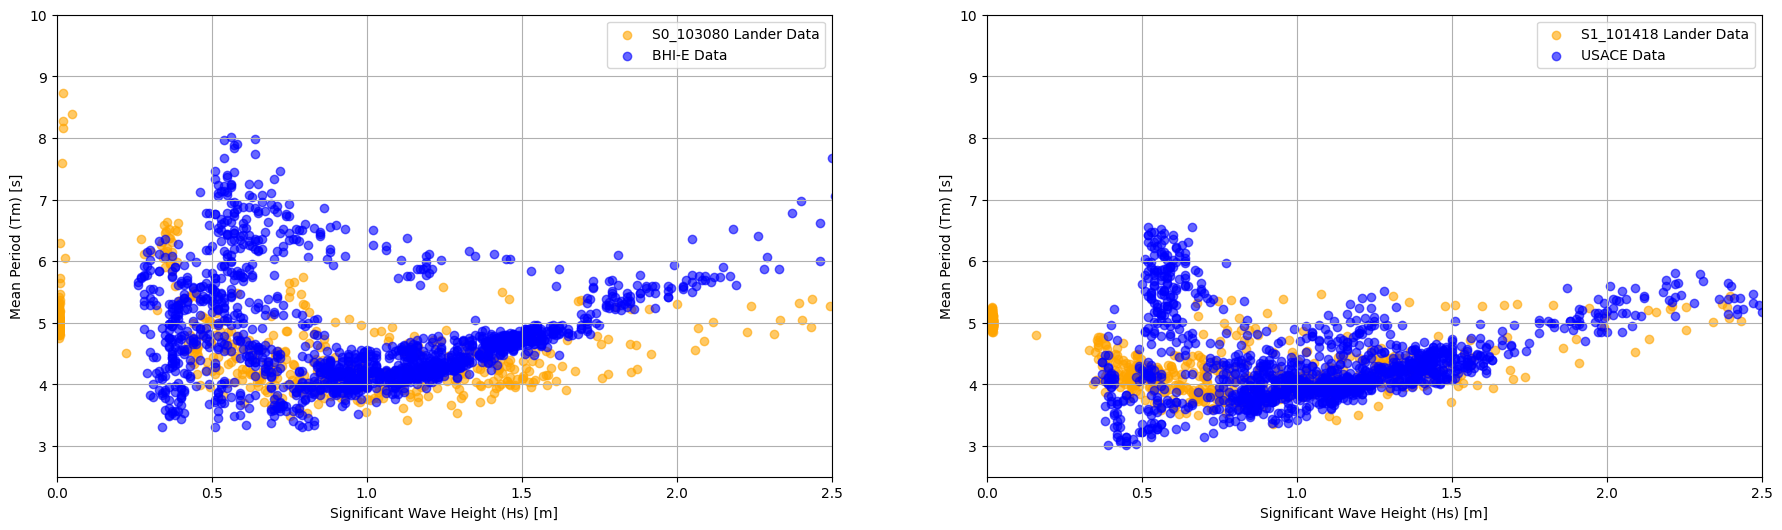

In [79]:
#Plot mean wave period vs significant wave height, you would expect larger waves to have longer periods
fig=plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
plt.scatter(waves_S0_103080['SignificantWaveHeight'], waves_S0_103080['MeanPeriod'], c='orange', alpha=0.6, label="S0_103080 Lander Data")
plt.scatter(Bdf['BSigWaveHeight'],Bdf['BMeanPeriod'], c='blue', alpha=0.6, label="BHI-E Data")

# Formatting
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel('Mean Period (Tm) [s]')
plt.ylim(2.5,10)
plt.xlim(0,2.5)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(waves_S1_101418['SignificantWaveHeight'], waves_S1_101418['MeanPeriod'], c='orange', alpha=0.6, label="S1_101418 Lander Data")
plt.scatter(USSigWaveHeight,USMeanPeriod, c='blue', alpha=0.6, label="USACE Data")

# Formatting
plt.xlabel('Significant Wave Height (Hs) [m]')
plt.ylabel('Mean Period (Tm) [s]')
plt.ylim(2.5,10)
plt.xlim(0,2.5)
plt.legend()
plt.grid(True)


plt.show()

**Sediment Transportation Analysis**

In [98]:
print(waves_E1_103071['SedTime'].iloc[:-1].shape)
print(waves_E1_103071['Echo1avg'].shape)

(8794091, 1)
(8794091, 1)


In [99]:
for i in sensor_id:
    waves = globals()[f"waves_{i}"]

    if i == "E1_103071":
        print("Calculating sediment stats for E1_103071")
        Sediment = calculate_sed_stats(
            waves["SedTime"].iloc[:-1],
            waves["Echo1avg"],
            event_time=starttime,
            end_time=endtime,
            fs=2,
            dtburst=86400 * 7,
            overlap=0.3,
            dtens=86400*7,
            mode="multitaper",
        )
    if i != "E1_103071":
        print(f"Calculating sediment stats for {i}")
        Sediment = calculate_sed_stats(
            waves["SedTime"],
            waves["Vertavg"],
            event_time=starttime,
            end_time=endtime,
            fs=4,
            dtburst=86400 * 7,
            overlap=0.3,
            dtens=86400*7,
            mode="multitaper",
        )

Calculating sediment stats for S1_101418
Calculating sediment stats for E1_103071
Calculating sediment stats for S0_103080


TypeError: concat() takes 1 positional argument but 2 were given

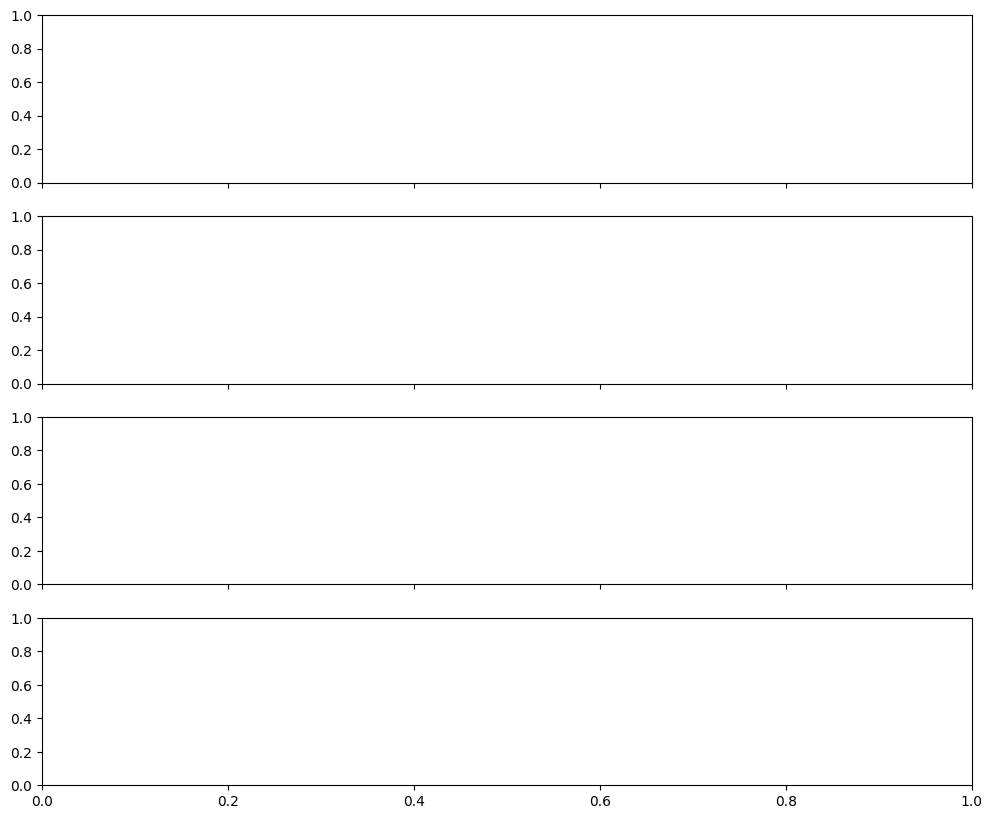

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

waves_E1_103071['Echo1avg'] = pd.concat(waves_E1_103071['Echo1avg'],pd.DataFrame([np.nan]))

E1avg, mask = despiker(despiker(waves_E1_103071['Echo1avg'], 3)[0],3)
S1avg, mask= despiker(despiker(waves_S1_101418['Vertavg'], 3)[0],3)
S0avg, mask = despiker(despiker(waves_S0_103080['Vertavg'], 3)[0],3)
E1avgVert, mask = despiker(despiker(waves_E1_103071['Vertavg'], 3)[0],3)

axs[0].plot(waves_E1_103071['SedTime'], E1avg, label='E1 Echosounder', color='blue')
axs[1].plot(waves_E1_103071['SedTime'], E1avgVert, label='E1 Vertical Beam', color='blue')
axs[2].plot(waves_S1_101418['SedTime'], S1avg, label='S1', color='red')
axs[3].plot(waves_S0_103080['SedTime'], S0avg, label='S0', color='green')

axs[0].set_ylim(30, 80)
axs[1].set_ylim(30, 100)
axs[2].set_ylim(30, 60)
axs[3].set_ylim(30, 60)
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Echo Intensity (dB)')
    ax.legend(loc='upper right')
    ax.grid(True)   
    ax.set_xlim(starttime, endtime)
plt.tight_layout()

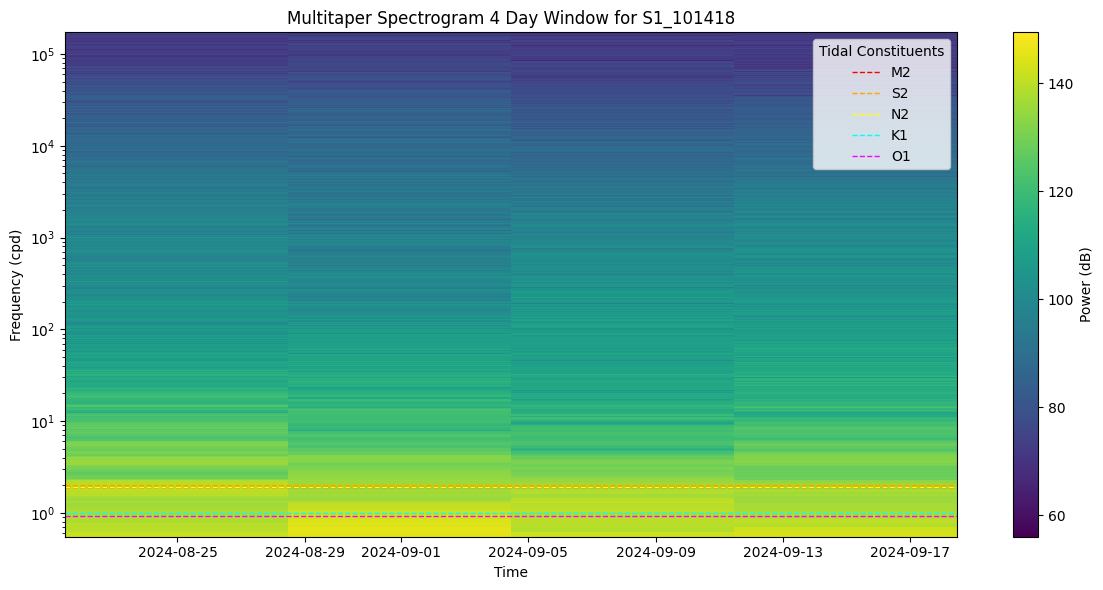

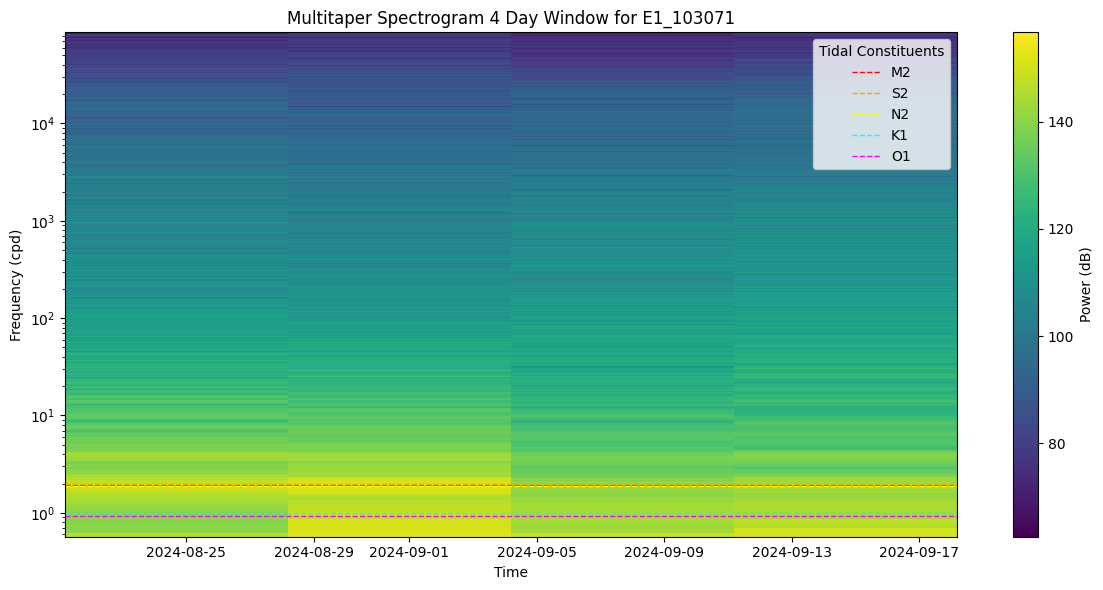

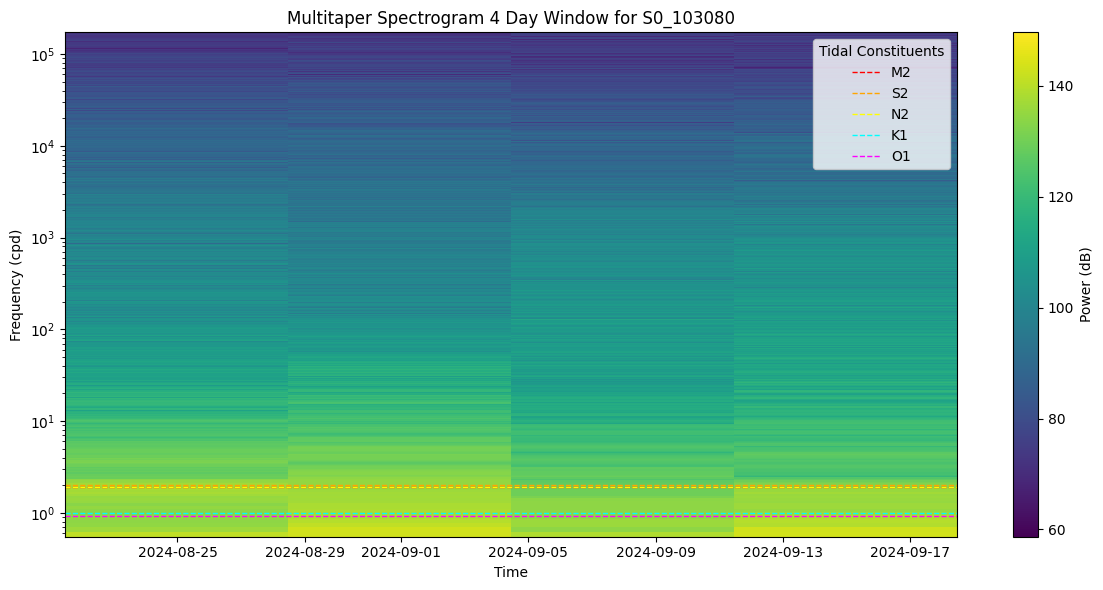

In [ ]:
for i in sensor_id:
    Sediment = globals()[f"Sediment_{i}"]
    waves = globals()[f"waves_{i}"]
    # Ensure start_time is a pandas Timestamp
    start_time = waves["SedTime"].iloc[0]  # already pd.Timestamp

    # Flatten Multi_time to 1D
    time_sec = np.ravel(Sediment["Multi_time"])

    # Define tidal frequencies in cycles/day (cpd)
    tidal_periods_hours = {
        'M2': 12.42,
        'S2': 12.00,
        'N2': 12.66,
        'K1': 23.93,
        'O1': 25.82
    }
    # Assign a color for each tidal constituent
    colors = {
        'M2': 'red',
        'S2': 'orange',
        'N2': 'yellow',
        'K1': 'cyan',
        'O1': 'magenta'
    }

    tidal_freqs_cpd = {name: 24 / period for name, period in tidal_periods_hours.items()}

    # Add timedelta to the timestamp
    time_dt = start_time[0] + pd.to_timedelta(time_sec, unit="s")

    # Convert PSD to dB
    Z = Sediment["Multi_psd"]
    freq_cpd = Sediment["Multi_freq"] * 86400  # 1 Hz = 86400 cpd

    T, F = np.meshgrid(time_dt, freq_cpd)

    plt.figure(figsize=(12, 6))
    pcm = plt.pcolormesh(T, F, Z, shading="auto")
    plt.colorbar(pcm, label="Power (dB)")

    plt.xlabel("Time")
    plt.ylabel("Frequency (cpd)")
    plt.yscale("log")
    plt.title(f"Multitaper Spectrogram 4 Day Window for {i}")

    # Plot tidal lines with legend
    for name, f in tidal_freqs_cpd.items():
        plt.axhline(y=f, color=colors[name], linestyle="--", linewidth=1, label=name)

    plt.legend(title="Tidal Constituents", loc="upper right")
    plt.tight_layout()
    plt.show()

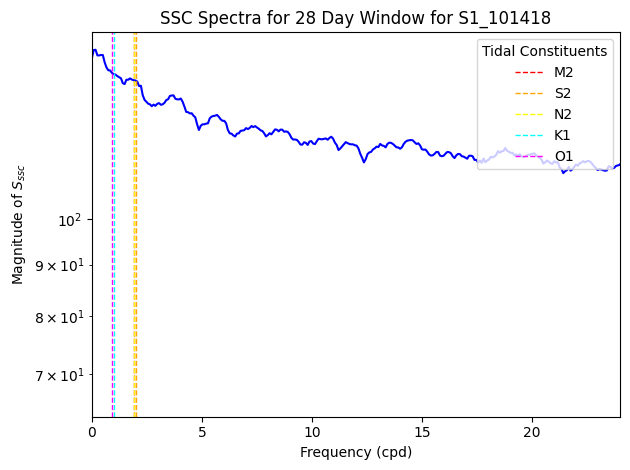

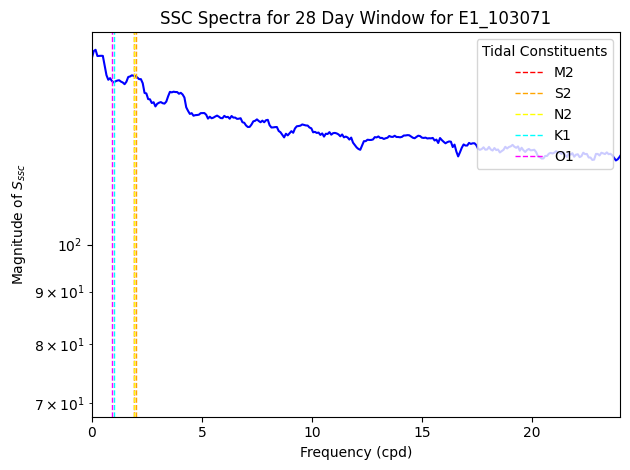

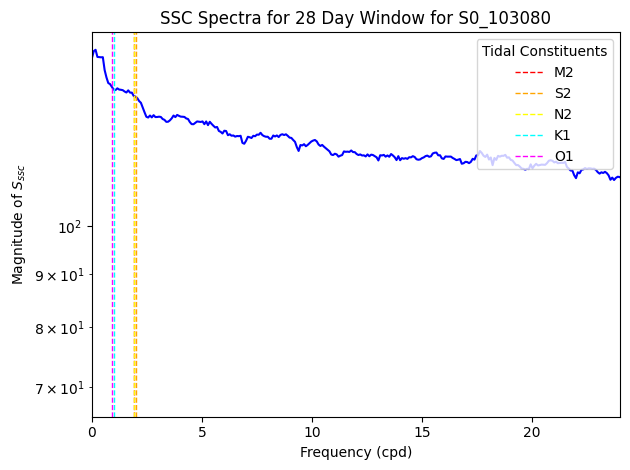

In [ ]:
for i in sensor_id:
    Sediment = globals()[f"Sediment_{i}"]
    waves = globals()[f"waves_{i}"]
    freq_cpd = Sediment["Multi_freq"] * 86400  # 1 Hz = 86400 cpd

    ###This code will plot the power spectra agaisnt frequencies
    plt.semilogy(
        freq_cpd, np.mean(Sediment["Multi_psd"], axis = 1), color="blue", label = "_nolegend_"
    )
    plt.title(f"SSC Spectra for 28 Day Window for {i}")
    plt.ylabel("Magnitude of $S_{ssc}$")
    plt.xlabel("Frequency (cpd)")
    plt.xlim(0, 24)
    plt.tight_layout()
    for name, f in tidal_freqs_cpd.items():
        plt.axvline(x=f, color=colors[name], linestyle="--", linewidth=1, label=name)
    plt.legend(title="Tidal Constituents", loc="upper right")
    plt.tight_layout()
    plt.show()

**Coherences and Correlations for ADCP Amplitudes and Flow Velocities**


In [ ]:
### Despike Full Velocities

E1Uvel, mask = despiker(despiker(waves_E1_103071['FullNorthVelocity'], 3)[0],3)
E1Vvel, mask = despiker(despiker(waves_E1_103071['FullEastVelocity'], 3)[0],3)
S1Uvel, mask= despiker(despiker(waves_S1_101418['FullNorthVelocity'], 3)[0],3)
S1Vvel, mask= despiker(despiker(waves_S1_101418['FullEastVelocity'], 3)[0],3)
S0Uvel, mask = despiker(despiker(waves_S0_103080['FullNorthVelocity'], 3)[0],3)
S0Vvel, mask = despiker(despiker(waves_S0_103080['FullEastVelocity'], 3)[0],3)


In [ ]:
import numpy as np
from scipy.signal.windows import dpss
from scipy.signal import butter, filtfilt


from scipy.signal.windows import dpss

def coherence_spectrum(u, v, A, fs, NW=3.0, Kmax=None, smooth_bins=7):
    """
    Multitaper coherence between U = u + i v and scalar A.

    u, v, A : 1D arrays (same length, same sampling)
    fs      : sampling rate (Hz)
    NW      : time-bandwidth product
    Kmax    : number of tapers (defaults to 2*NW - 1)
    smooth_bins : integer, moving-average smoothing in frequency
    """
    u = np.asarray(u, float).ravel()
    v = np.asarray(v, float).ravel()
    A = np.asarray(A, float).ravel()

    U = u + 1j * v

    # Demean & fill NaNs
    U -= np.nanmean(U)
    A -= np.nanmean(A)
    U = np.nan_to_num(U, nan=0.0)
    A = np.nan_to_num(A, nan=0.0)

    N = len(U)

    if Kmax is None:
        Kmax = int(2*NW - 1)

    tapers, eigs = dpss(N, NW, Kmax, return_ratios=True)

    Sxx = np.zeros(N, float)
    Syy = np.zeros(N, float)
    Sxy = np.zeros(N, complex)

    for k in range(Kmax):
        Uk = U * tapers[k]
        Ak = A * tapers[k]

        Xk = np.fft.fft(Uk)
        Yk = np.fft.fft(Ak)

        Sxx += np.abs(Xk)**2
        Syy += np.abs(Yk)**2
        Sxy += Yk * np.conj(Xk)

    Sxx /= Kmax
    Syy /= Kmax
    Sxy /= Kmax

    # Frequency smoothing
    if smooth_bins > 1:
        kern = np.ones(smooth_bins) / smooth_bins
        Sxx = np.convolve(Sxx, kern, mode="same")
        Syy = np.convolve(Syy, kern, mode="same")
        Sxy = np.convolve(Sxy, kern, mode="same")

    eps = 1e-12
    Coh_complex = Sxy / (np.sqrt(Sxx * Syy) + eps)

    f = np.fft.fftfreq(N, d=1/fs)
    pos = f > 0
    f = f[pos]
    Coh_complex = Coh_complex[pos]

    Coh_mag = np.abs(Coh_complex)
    Coh_phase = np.angle(Coh_complex)

    return f, Coh_mag, Coh_phase




def downsample_antialias(signal, fs, fs_new, order=4):
    signal = np.asarray(signal).squeeze().astype(float)

    if fs_new >= fs:
        raise ValueError("fs_new must be smaller than fs")

    # Integer decimation factor
    q = int(np.round(fs / fs_new))
    fs_eff = fs / q

    # Butterworth low-pass filter just below new Nyquist
    fc = 0.45 * fs_eff  # cutoff Hz
    b, a = butter(order, fc / (0.5 * fs), btype="low")

    # Adaptive pad length for safety
    padlen = min(3 * max(len(a), len(b)), signal.size - 1)

    y_filt = filtfilt(b, a, signal, padlen=padlen)
    y_ds = y_filt[::q]

    return y_ds, fs_eff


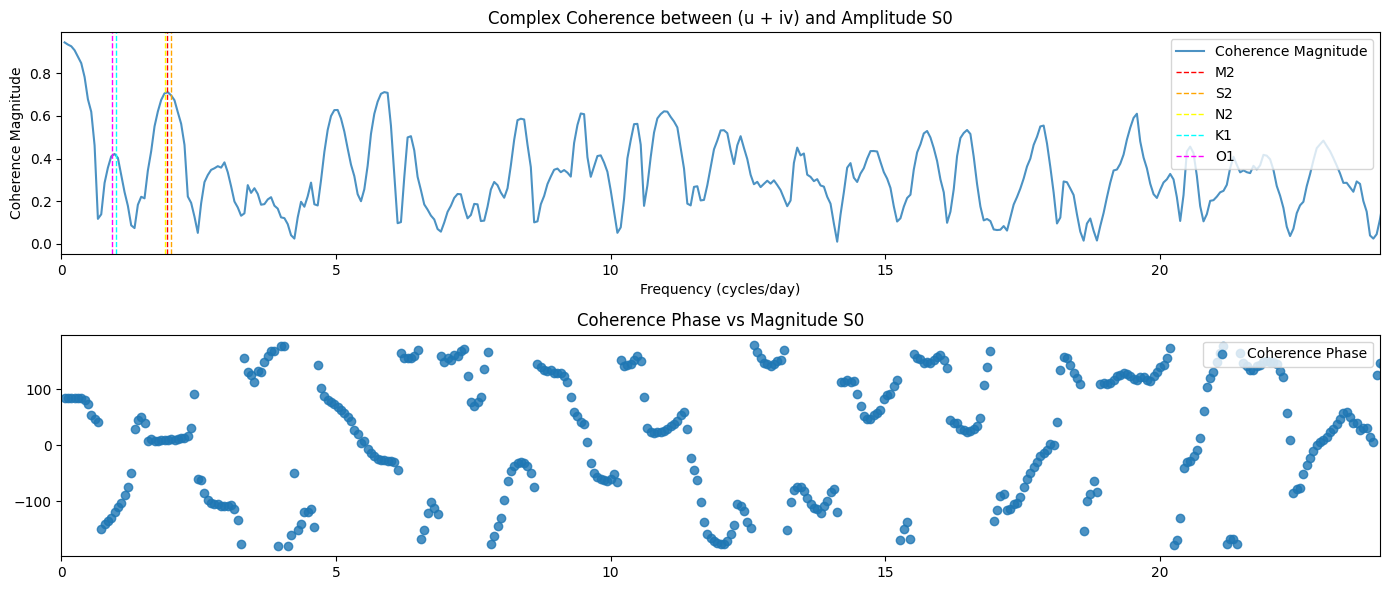

In [ ]:
N = len(S0Uvel)
mid = N // 2

U_front = S0Uvel[:mid]
V_front = S0Vvel[:mid]
A_front = S0avg[:mid]

U_back  = S0Uvel[mid:]
V_back  = S0Vvel[mid:]
A_back  = S0avg[mid:]

# Multitaper coherence
f, Coh_mag, Coh_phase = coherence_spectrum(
    U_front, V_front, A_front,
    fs=4,
    NW=3.0,          # gives Δf ~ 0.1–0.15 cpd over 25 days
    smooth_bins=7
)
f_cpd = f * 86400

# Only keep non-negative frequencies
pos = f_cpd >= 0
f_pos = f_cpd[pos]
Coh_pos = Coh_mag[pos]

fig,[ax1,ax2] = plt.subplots(2,1, figsize=(14, 6))

ax1.plot(f_pos, Coh_pos, label="Coherence Magnitude", alpha=0.8)

for name, f in tidal_freqs_cpd.items():
        ax1.axvline(x=f, color=colors[name], linestyle="--", linewidth=1, label=name)

ax1.set_xlabel("Frequency (cycles/day)")
ax1.set_ylabel("Coherence Magnitude")
ax1.set_title("Complex Coherence between (u + iv) and Amplitude S0")
ax1.set_xlim(0, 24)
ax1.legend(loc='upper right')

ax2.scatter(f_pos, np.degrees(Coh_phase[pos]), label="Coherence Phase", alpha=0.8)
ax2.set_title("Coherence Phase vs Magnitude S0")
ax2.legend(loc='upper right')
ax2.set_xlim(0, 24)
plt.tight_layout()
plt.show()


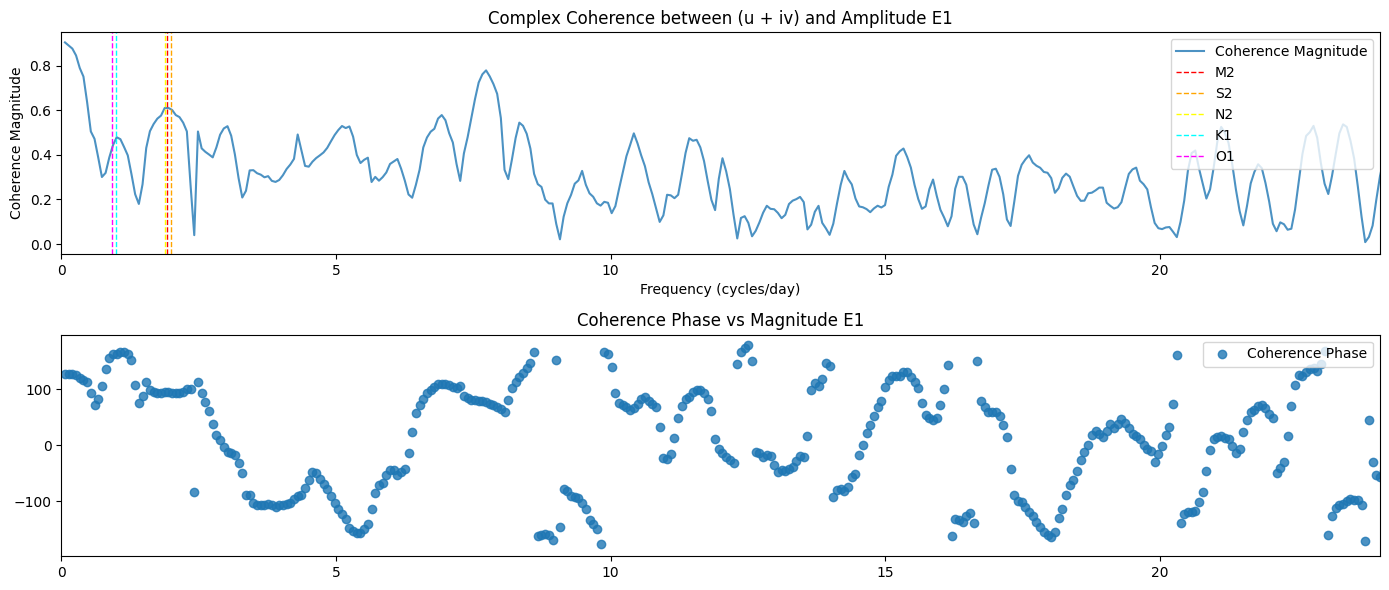

In [ ]:
N = len(E1Uvel)
mid = N // 2

U_front = E1Uvel[:mid]
V_front = E1Vvel[:mid]
A_front = E1avg[:mid]

U_back  = E1Uvel[mid:]
V_back  = E1Vvel[mid:]
A_back  = E1avg[mid:]

# Multitaper coherence
f, Coh_mag, Coh_phase = coherence_spectrum(
    U_front, V_front, A_front,
    fs=2,
    NW=3.0,          
    smooth_bins=7
)
f_cpd = f * 86400

# Only keep non-negative frequencies
pos = f_cpd >= 0
f_pos = f_cpd[pos]
Coh_pos = Coh_mag[pos]

fig,[ax1,ax2] = plt.subplots(2,1, figsize=(14, 6))

ax1.plot(f_pos, Coh_pos, label="Coherence Magnitude", alpha=0.8)

for name, f in tidal_freqs_cpd.items():
        ax1.axvline(x=f, color=colors[name], linestyle="--", linewidth=1, label=name)

ax1.set_xlabel("Frequency (cycles/day)")
ax1.set_ylabel("Coherence Magnitude")
ax1.set_title("Complex Coherence between (u + iv) and Amplitude E1")
ax1.set_xlim(0, 24)
ax1.legend(loc='upper right')

ax2.scatter(f_pos, np.degrees(Coh_phase[pos]), label="Coherence Phase", alpha=0.8)
ax2.set_title("Coherence Phase vs Magnitude E1")
ax2.legend(loc='upper right')
ax2.set_xlim(0, 24)
plt.tight_layout()
plt.show()


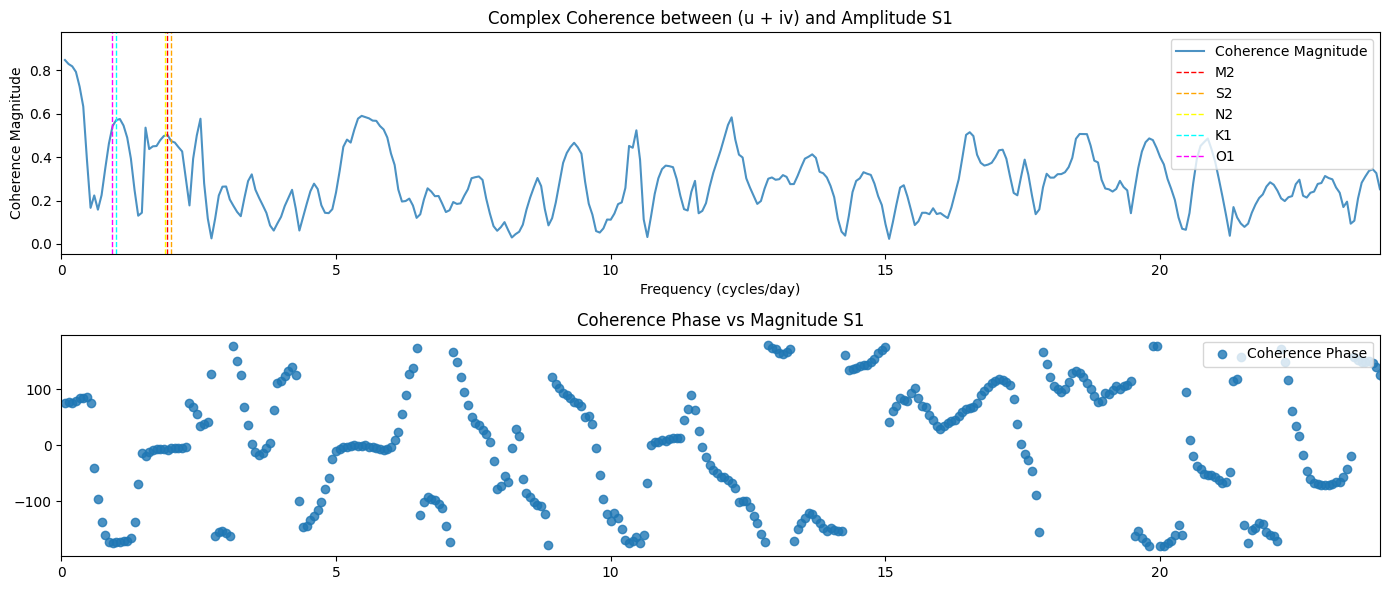

In [ ]:
N = len(S1Uvel)
mid = N // 2

U_front = S1Uvel[:mid]
V_front = S1Vvel[:mid]
A_front = S1avg[:mid]

U_back  = S1Uvel[mid:]
V_back  = S1Vvel[mid:]
A_back  = S1avg[mid:]

# Multitaper coherence
f, Coh_mag, Coh_phase = coherence_spectrum(
    U_front, V_front, A_front,
    fs=4,
    NW=3.0,          # gives Δf ~ 0.1–0.15 cpd over 25 days
    smooth_bins=7
)
f_cpd = f * 86400

# Only keep non-negative frequencies
pos = f_cpd >= 0
f_pos = f_cpd[pos]
Coh_pos = Coh_mag[pos]

fig,[ax1,ax2] = plt.subplots(2,1, figsize=(14, 6))

ax1.plot(f_pos, Coh_pos, label="Coherence Magnitude", alpha=0.8)

for name, f in tidal_freqs_cpd.items():
        ax1.axvline(x=f, color=colors[name], linestyle="--", linewidth=1, label=name)

ax1.set_xlabel("Frequency (cycles/day)")
ax1.set_ylabel("Coherence Magnitude")
ax1.set_title("Complex Coherence between (u + iv) and Amplitude S1")
ax1.set_xlim(0, 24)
ax1.legend(loc='upper right')

ax2.scatter(f_pos, np.degrees(Coh_phase[pos]), label="Coherence Phase", alpha=0.8)
ax2.set_title("Coherence Phase vs Magnitude S1")
ax2.legend(loc='upper right')
ax2.set_xlim(0, 24)
plt.tight_layout()
plt.show()
